<h1><center>CSCI 4146/6409 - Process of Data Science (Summer 2023)</h1>
<h1><center>Final Project</h1>

<b><center>Camilo Vargas</b>
<center>B00926233</center>


# 1. Data Exploration


In [1]:
# Import Libraries:

#!pip install yfinance #!pip install mplfinance # !pip install xgboost !pip install keras !pip install tensorflow !pip install pandas_datareader
# !pip install pycaret, markupsafe, jinja2
import pandas as pd
import numpy as np
import plotly as py
from plotly import tools
import plotly.graph_objs as go
import pandas_datareader as web
from datetime import datetime
import yfinance as yf
import mplfinance as mpf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score, cross_validate
import xgboost as xgb
import math
from numpy import mean, std, sqrt
from pycaret.regression import *
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from datetime import datetime
time_start = datetime.now()

In [2]:
# Source: https://finance.yahoo.com/currencies
# example USD/EUR = USDEUR=X, in other words how many Euros cost one US Dollar
# change date range here
start_date = '2020-01-01'
end_date = '2023-07-01'
Currency = 'USDCOP' 
# retrieve market data of currency symbol
data = yf.download(Currency+'=X', start=start_date, end=end_date)
data #.info()
# data = data.drop_duplicates(keep=False) #Check if duplicates dates or values has to be dropped.
# data.isna().sum()

[*********************100%***********************]  1 of 1 completed


Open         High          Low        Close    Adj Close  \
Date                                                                          
2020-01-01  3279.760010  3279.760010  3279.760010  3279.760010  3279.760010   
2020-01-02  3279.760010  3281.080078  3241.714111  3279.760010  3279.760010   
2020-01-03  3252.750000  3266.750000  3252.469971  3252.750000  3252.750000   
2020-01-06  3252.250000  3253.560059  3245.520020  3256.899902  3256.899902   
2020-01-07  3244.459961  3262.600098  3202.010742  3244.459961  3244.459961   
...                 ...          ...          ...          ...          ...   
2023-06-26  4187.250000  4187.250000  4041.498291  4187.250000  4187.250000   
2023-06-27  4162.180176  4166.729980  4142.229980  4162.180176  4162.180176   
2023-06-28  4164.750000  4194.979980  4123.991699  4164.750000  4164.750000   
2023-06-29  4149.700195  4184.799805  4146.379883  4149.700195  4149.700195   
2023-06-30  4167.850098  4184.779785  4165.750000  4167.850098  4167.850098   

            Volume  
Date                
2020-01-01       0  
2020-01-02       0  
2020-01-03       0  
2020-01-06       0  
2020-01-07       0  
...            ...  
2023-06-26       0  
2023-06-27       0  
2023-06-28       0  
2023-06-29       0  
2023-06-30       0  

[913 rows x 6 columns]

In [3]:
# Retrieve financial market data of currency symbol

Currencies=['USDBRL', 'USDMXN', 'USDCOP', 'USDARS', 'USDNGN', 'USDPHP', 'USDTRY', 'USDRUB', 'USDINR', 'USDCNY']
currencies_names = ['Brazilian Real - USDBRL', 'Mexican Peso - USDMXN', 'Colombian Peso - USDCOP', 'Argentine Peso - USDARS', 'Nigerian Naira - USDNGN',
                  'Philippine Peso - USDPHP', 'Turkish Lira - USDTRY', 'Russian Ruble - USDRUB', 'Indian Rupee - USDINR', 'Chinese Yuan - USDCNY']

# dataframes = [data_BRL, data_MXN, data_COP, data_ARS, data_NGN, data_PHP, data_TRY, data_RUB, data_INR, data_CNY]
dataframes = []

for i in Currencies:
    data_X = yf.download(i+'=X', start=start_date, end=end_date)
    dataframes.append(data_X)#

for currency, df in zip(Currencies, dataframes):
    print('\n \033[1m' + currency + '\033[0m')
    print(df)
    print(df.isna().sum())

# dataframes

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 USDBRL
                Open      High       Low     Close  Adj Close  Volume
Date                                                                 
2020-01-01  4.016786  4.018200  4.016300  4.016786   4.016786       0
2020-01-02  4.016300  4.038700  4.000820  4.016300   4.016300       0
2020-01-03  4.023700 

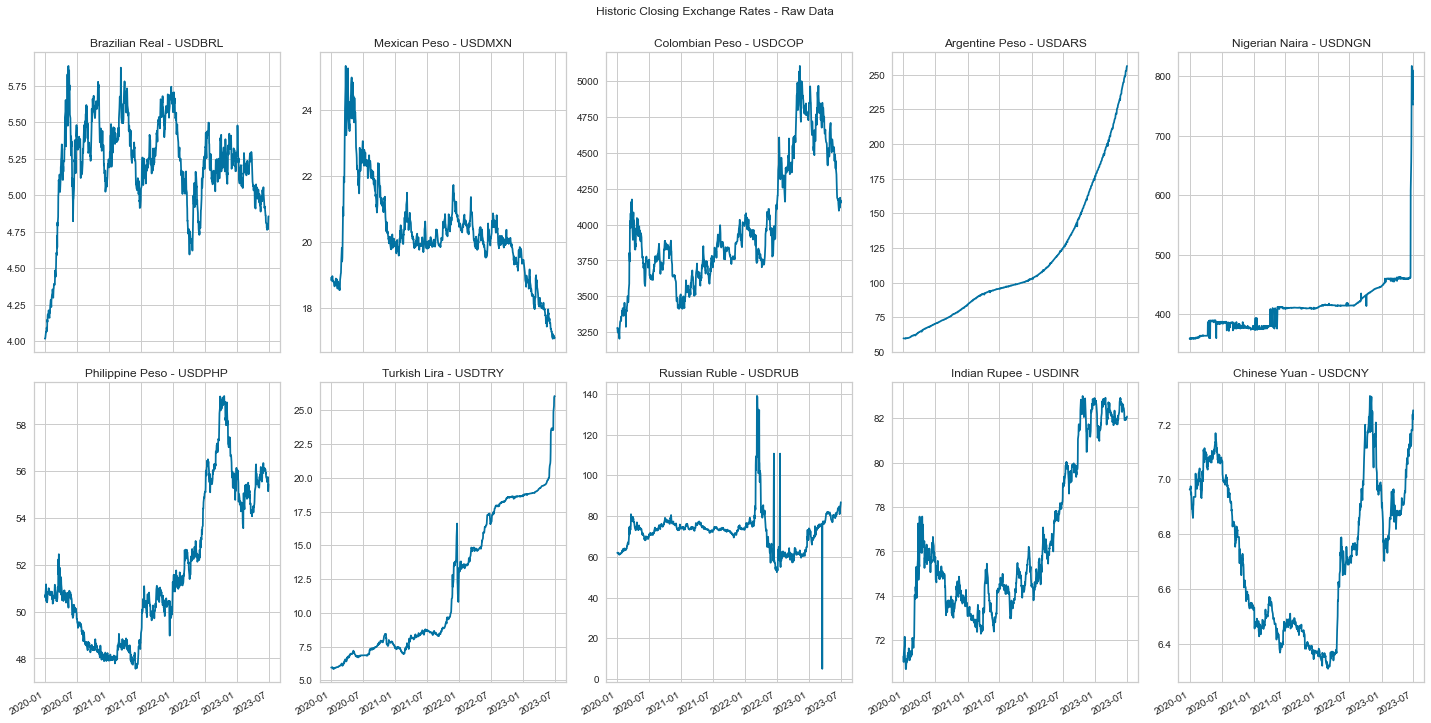

In [4]:
# Create a figure with 10 subplots arranged in a 2x5 grid

fig, axes = plt.subplots(2, 5, figsize=(20, 10))
plt.suptitle("Historic Closing Exchange Rates - Raw Data").set_y(1)

# Add data to the subplots
for df, ax, currency, name in zip(dataframes, axes.flatten(), Currencies, currencies_names):
    ax.plot(df['Close'])
    ax.set_title(name)
    plt.gcf().autofmt_xdate()  
    ax.grid(True)

plt.tight_layout()

# 2. Data Preparation

In [5]:
# Define cleaning functions:

# Add new column with the Close change percent between rows
def add_pct_change(df):
    if any(col in df.columns for col in set(['Close_Change_Pct', 'Close_Change_Pct_x', 'Close_Change_Pct_y'])):
        df.drop(['Close_Change_Pct'], axis=1, inplace=True, errors='ignore')
        df['Close_Change_Pct'] = df['Close'].pct_change()
    else:
        df['Close_Change_Pct'] = df['Close'].pct_change()
    return df.sort_values(by='Close_Change_Pct', ascending=True).head(10) # Sort the dates with the largest change pct

# Where the Close change pct is <= -70% it is replaced to the previous value
def replace_close(df):
    for row in range(0,len(df)):
        df['Close'] = np.where((df['Close_Change_Pct'] <= -0.7), df['Close'].shift(1), df['Close'])

# Feature Creation: Create time series features per period
def Feature_Creation(df):
    df.drop(['CloseScaled','DayOfWeek','Month','Quarter','Year','Prediction'], axis=1, inplace=True, errors='ignore')
    df['CloseScaled'] = MinMaxScaler().fit_transform(df.filter(['Close']).values)
    df['DayOfWeek'] = df.index.dayofweek
    df['Month'] = df.index.month
    df['Quarter'] = df.index.quarter
    df['Year'] = df.index.year
    return df

In [6]:
# Apply cleaning functions
for df in dataframes:
    add_pct_change(df)
    replace_close(df)
    replace_close(df)
    Feature_Creation(df)

dataframes[2] # return example df_COP after performing functions

Open         High          Low        Close    Adj Close  \
Date                                                                          
2020-01-01  3279.760010  3279.760010  3279.760010  3279.760010  3279.760010   
2020-01-02  3279.760010  3281.080078  3241.714111  3279.760010  3279.760010   
2020-01-03  3252.750000  3266.750000  3252.469971  3252.750000  3252.750000   
2020-01-06  3252.250000  3253.560059  3245.520020  3256.899902  3256.899902   
2020-01-07  3244.459961  3262.600098  3202.010742  3244.459961  3244.459961   
...                 ...          ...          ...          ...          ...   
2023-06-26  4187.250000  4187.250000  4041.498291  4187.250000  4187.250000   
2023-06-27  4162.180176  4166.729980  4142.229980  4162.180176  4162.180176   
2023-06-28  4164.750000  4194.979980  4123.991699  4164.750000  4164.750000   
2023-06-29  4149.700195  4184.799805  4146.379883  4149.700195  4149.700195   
2023-06-30  4167.850098  4184.779785  4165.750000  4167.850098  4167.850098   

            Volume  Close_Change_Pct  CloseScaled  DayOfWeek  Month  Quarter  \
Date                                                                           
2020-01-01       0               NaN     0.039808          2      1        1   
2020-01-02       0          0.000000     0.039808          3      1        1   
2020-01-03       0         -0.008235     0.025607          4      1        1   
2020-01-06       0          0.001276     0.027789          0      1        1   
2020-01-07       0         -0.003820     0.021248          1      1        1   
...            ...               ...          ...        ...    ...      ...   
2023-06-26       0          0.017496     0.516944          0      6        2   
2023-06-27       0         -0.005987     0.503763          1      6        2   
2023-06-28       0          0.000617     0.505114          2      6        2   
2023-06-29       0         -0.003614     0.497201          3      6        2   
2023-06-30       0          0.004374     0.506744          4      6        2   

            Year  
Date              
2020-01-01  2020  
2020-01-02  2020  
2020-01-03  2020  
2020-01-06  2020  
2020-01-07  2020  
...          ...  
2023-06-26  2023  
2023-06-27  2023  
2023-06-28  2023  
2023-06-29  2023  
2023-06-30  2023  

[913 rows x 12 columns]

## 2.1 Data Insights

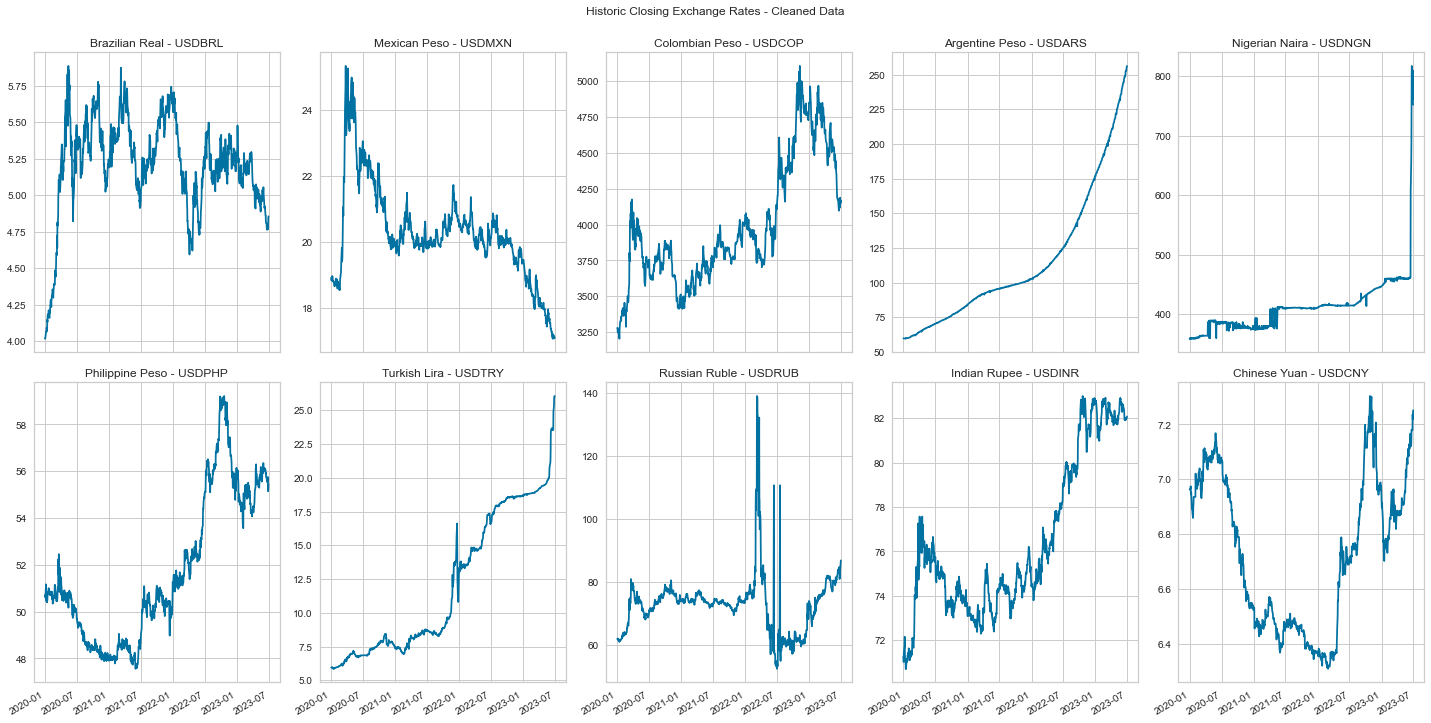

In [7]:
# Visualize Cleaned Data

# Create a figure with 10 subplots arranged in a 5x2 grid
fig, axes = plt.subplots(2,5, figsize=(20,10))
plt.suptitle("Historic Closing Exchange Rates - Cleaned Data").set_y(1)

for df, ax, currency, name in zip(dataframes, axes.flatten(), Currencies, currencies_names):
    ax.plot(df['Close'])
    plt.gcf().autofmt_xdate()
    # ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_title(name)
    ax.grid(True)
plt.tight_layout()

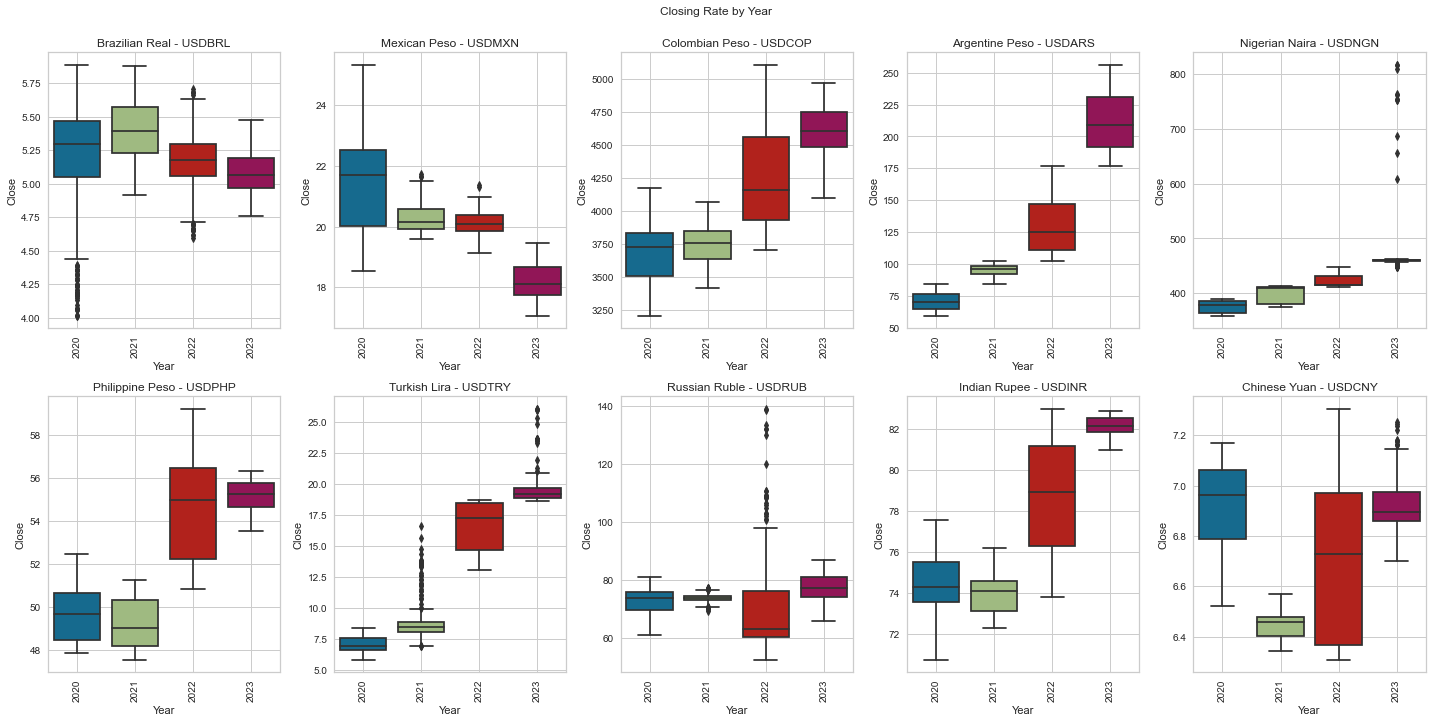

In [8]:
# Visualize Feature / Target Relationship # Check the DayOfWeek	Month	Quarter	Year
# Horizontal plots
fig, axes = plt.subplots(2,5, figsize=(20,10))
plt.suptitle("Closing Rate by Year").set_y(1)

for df, ax, currency, name in zip(dataframes, axes.flatten(), Currencies, currencies_names):
    sns.boxplot(y='Close', x= 'Year', data=df, ax=ax, orient='v').set_title(name)#
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    # x_ticks, x_labels = plt.xticks()# Get the current x tick labels and positions
    # plt.xticks(x_ticks[::2], x_labels[::2])# Set the x tick labels and positions to only include every other label
    ax.grid(True)
plt.tight_layout()

# plt.savefig("Closing Rate by Year.png") #save image file in current working directory

In [9]:
# MA = data.Close.rolling(center=False, window=30).mean() #Moving Average of the previous 30 days
# trace0 = go.Ohlc(x=data.index, open=data.Open, high=data.High, low=data.Low, close=data.Close, name='Currency Quote')
# trace1 = go.Scatter(x=data.index, y=MA)
# trace2 = go.Bar(x=data.index, y=data.Volume)
 # Create an html page with the dinamic graph
# data_trace = [trace0, trace1, trace2 ]
# py.offline.plot(data_trace, filename='Currency Quote USDCOP.html')
# fig = py.subplots.make_subplots(rows=2, cols=1, shared_xaxes=True)
# fig.append_trace(trace0, 1,1) 
# fig.append_trace(trace1, 1,1) 
# fig.append_trace(trace2, 2,1) 
# py.offline.plot(fig.html') # Create an html page with the dinamic 'fig', filename='Currency Quote USDCOP

# 3. ML Models


## 3.1 Extreme Gradient Boosting XGB Regressor

[*********************100%***********************]  1 of 1 completed
Train shape: (639, 1)
Test shape: (274, 1)


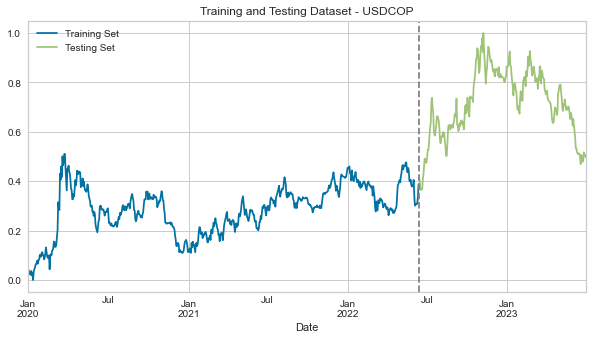

In [10]:
# Retrieve market data of currency symbol
Currency = 'USDCOP'
data = yf.download(Currency+'=X', start=start_date, end=end_date)

# Training and Testing Dataset
split_date = int(len(data) * 0.7)# date split for a standard parameter, e.g. 70% train or 30% test

# Apply cleaning functions on data
add_pct_change(data)
replace_close(data)
replace_close(data)
Feature_Creation(data)

train_df = pd.DataFrame(data.CloseScaled.iloc[ :split_date]) # Train in 70% of first dates
test_df = pd.DataFrame(data.CloseScaled.iloc[split_date: ]) # Test in 30% after split
print(f'Train shape: {train_df.shape}')
print(f'Test shape: {test_df.shape}')

# plot the training and test sets
fig, ax = plt.subplots(figsize=(10,5))
train_df.plot(ax=ax, label='Training Set', title=f'Training and Testing Dataset - {Currency}')
test_df.plot(ax=ax, label='Testing Set')
ax.axvline(data.index[split_date], color='grey', ls='--')
ax.legend(['Training Set', 'Testing Set'])
ax.grid(True)
plt.show()

In [11]:
# Create model XGBRegressor

X_train_df = data[['DayOfWeek', 'Month', 'Quarter', 'Year']].iloc[ :split_date]
y_train_df = data[['CloseScaled']].iloc[ :split_date]

X_test_df = data[['DayOfWeek', 'Month', 'Quarter', 'Year']].iloc[split_date: ]
y_test_df = data[['CloseScaled']].iloc[split_date: ]

reg = xgb.XGBRegressor(n_estimators = 1000, early_stopping_rounds =50, learning_rate = 0.01)
reg.fit(X_train_df, y_train_df, eval_set=[(X_train_df, y_train_df), (X_test_df, y_test_df)], verbose=100)

[0]	validation_0-rmse:0.23336	validation_1-rmse:0.25464
[49]	validation_0-rmse:0.14870	validation_1-rmse:0.30207


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

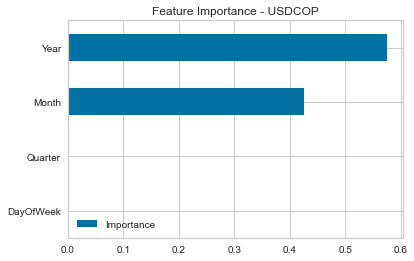

In [12]:
# Feature Importance
Importance = pd.DataFrame(reg.feature_importances_, index=reg.feature_names_in_, columns=['Importance'])
Importance.sort_values('Importance').plot(kind='barh', title=f'Feature Importance - {Currency}')
plt.show()

In [13]:
# Forecast on Test set
test_df['Prediction'] = reg.predict(X_test_df) # Add the predictions in a new column

# merge the predictions with the initial df
if any(col in data.columns for col in set(['Prediction', 'Prediction_x', 'Prediction_y'])):
    data.drop(['Prediction','Prediction_x','Prediction_y'], axis=1, inplace=True, errors='ignore')
    data = data.merge(test_df['Prediction'], how='left', left_index=True, right_index=True)
else:
    data = data.merge(test_df['Prediction'], how='left', left_index=True, right_index=True)

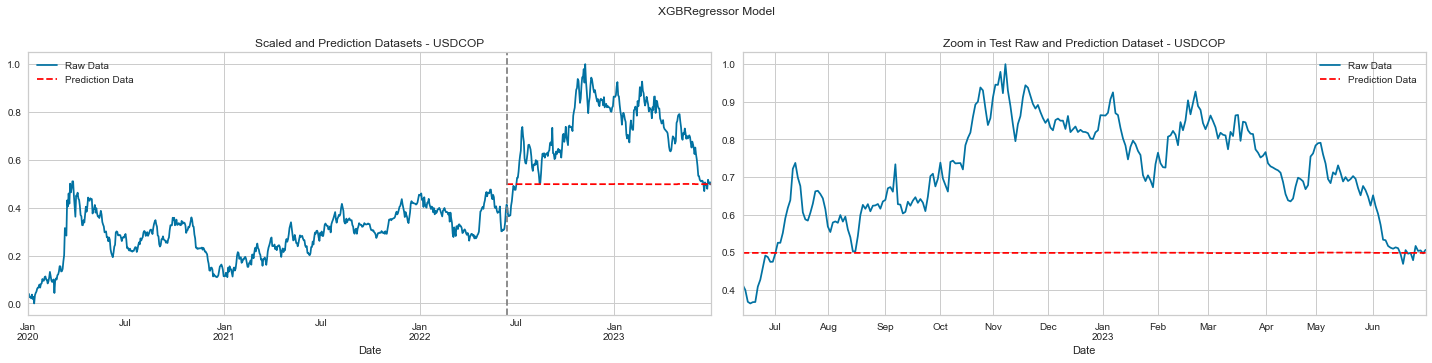

In [14]:
# Visualize Scaled / Predictions and Zoom in

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
plt.suptitle("XGBRegressor Model").set_y(1)

data[['CloseScaled']].plot(ax=ax1, title=f'Scaled and Prediction Datasets - {Currency}')
data[['Prediction']].plot(ax=ax1, style='--', color='red').grid(True)
ax1.axvline(data.index[split_date], color='grey', ls='--')
ax1.legend(['Raw Data', 'Prediction Data'])

data.loc[data.index >= data.index[split_date]]['CloseScaled'].plot(ax=ax2, title=f'Zoom in Test Raw and Prediction Dataset - {Currency}')
data.loc[data.index >= data.index[split_date]]['Prediction'].plot(ax=ax2, style='--', color='red').grid(True)
ax2.axvline(data.index[split_date], color='grey', ls='--')
ax2.legend(['Raw Data', 'Prediction Data'])

plt.tight_layout()

In [15]:
RMSE = np.sqrt(mean_squared_error(test_df['CloseScaled'], test_df['Prediction']))
print(f'{Currency} - RMSE Score on Test Set: {RMSE: 0.2f}') # This should be the same score as validation_1-rmse

USDCOP - RMSE Score on Test Set:  0.25


In [16]:
# Calculate Error: Check the worst and best predicted days
test_df['Error'] = np.abs(test_df['CloseScaled'] - test_df['Prediction'])
test_df['Error'].sort_values(ascending=False) #.head(10)

Date
2022-11-08    0.501492
2022-11-04    0.481045
2022-11-02    0.446943
2022-11-03    0.446433
2022-11-18    0.445324
                ...   
2023-06-16    0.003121
2023-06-21    0.002148
2022-07-01    0.001349
2023-06-29    0.001307
2023-06-22    0.000165
Name: Error, Length: 274, dtype: float64

**Perform XGB across all currencies**

In [17]:
# Define XGB functions:

def XGB_Model(data):

    # Apply cleaning functions on data
    add_pct_change(data)
    replace_close(data)
    replace_close(data)
    Feature_Creation(data)

    train_df = pd.DataFrame(data.CloseScaled.iloc[ :split_date]) # Train in 70% of first dates
    test_df = pd.DataFrame(data.CloseScaled.iloc[split_date: ]) # Test in 30% after split

    X_train_df = data[['DayOfWeek', 'Month', 'Quarter', 'Year']].iloc[ :split_date]
    y_train_df = data[['CloseScaled']].iloc[ :split_date]
    X_test_df = data[['DayOfWeek', 'Month', 'Quarter', 'Year']].iloc[split_date: ]
    y_test_df = data[['CloseScaled']].iloc[split_date: ]

    reg = xgb.XGBRegressor(n_estimators = 1000, early_stopping_rounds =50, learning_rate = 0.01)
    reg.fit(X_train_df, y_train_df, eval_set=[(X_train_df, y_train_df), (X_test_df, y_test_df)], verbose=100)

    test_df['Prediction'] = reg.predict(X_test_df) # Add the predictions in a new column

    # Merge the predictions with the initial df
    if any(col in data.columns for col in set(['Prediction', 'Prediction_x', 'Prediction_y'])):
        data.drop(['Prediction','Prediction_x','Prediction_y'], axis=1, inplace=True, errors='ignore')
        data = data.merge(test_df['Prediction'], how='left', left_index=True, right_index=True)
    else:
        data = data.merge(test_df['Prediction'], how='left', left_index=True, right_index=True)

    RMSE = np.sqrt(mean_squared_error(test_df['CloseScaled'], test_df['Prediction']))
    print(f'{Currency} - RMSE Score on Test Set: {RMSE: 0.3f}') # This should be the same score as validation_1-rmse

    # Optimized visuals
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
    plt.suptitle("XGBRegressor Model").set_y(1)
    axes = [ax1, ax2]
    titles = [f'Scaled and Prediction Data - {Currency}', f'Zoom in Test Raw and Prediction Data - {Currency}']
    data_to_plot = [data[['CloseScaled', 'Prediction']], data.loc[data.index >= data.index[split_date], ['CloseScaled', 'Prediction']]]
    for ax, title, data_to in zip(axes, titles, data_to_plot):
        data_to['CloseScaled'].plot(ax=ax, title=title)
        data_to['Prediction'].plot(ax=ax, style='--', color='red').grid(True)
        ax.axvline(data.index[split_date], color='grey', ls='--')
        ax.legend(['Raw Data', 'Prediction Data'])
        plt.tight_layout()

    return 

# XGB_Model(data)

[0]	validation_0-rmse:0.25070	validation_1-rmse:0.13796
[100]	validation_0-rmse:0.11026	validation_1-rmse:0.09977
[119]	validation_0-rmse:0.09761	validation_1-rmse:0.10479
USDBRL - RMSE Score on Test Set:  0.096
[0]	validation_0-rmse:0.16551	validation_1-rmse:0.28013
[100]	validation_0-rmse:0.08117	validation_1-rmse:0.22171
[200]	validation_0-rmse:0.06009	validation_1-rmse:0.20062
[300]	validation_0-rmse:0.05625	validation_1-rmse:0.19325
[400]	validation_0-rmse:0.05558	validation_1-rmse:0.19080
[500]	validation_0-rmse:0.05540	validation_1-rmse:0.18975
[600]	validation_0-rmse:0.05533	validation_1-rmse:0.18921
[700]	validation_0-rmse:0.05529	validation_1-rmse:0.18891
[800]	validation_0-rmse:0.05527	validation_1-rmse:0.18874
[900]	validation_0-rmse:0.05527	validation_1-rmse:0.18873
[999]	validation_0-rmse:0.05527	validation_1-rmse:0.18873
USDMXN - RMSE Score on Test Set:  0.189
[0]	validation_0-rmse:0.23336	validation_1-rmse:0.25464
[49]	validation_0-rmse:0.14870	validation_1-rmse:0.30207

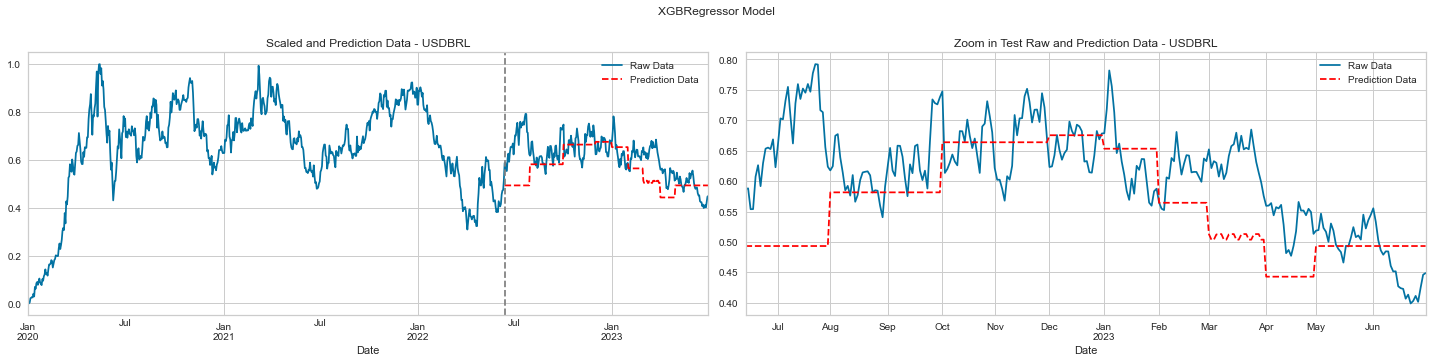

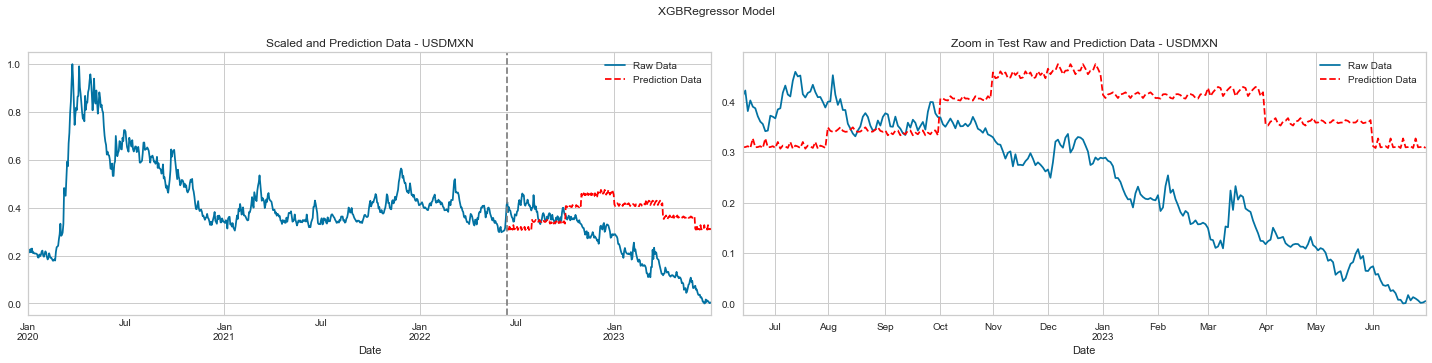

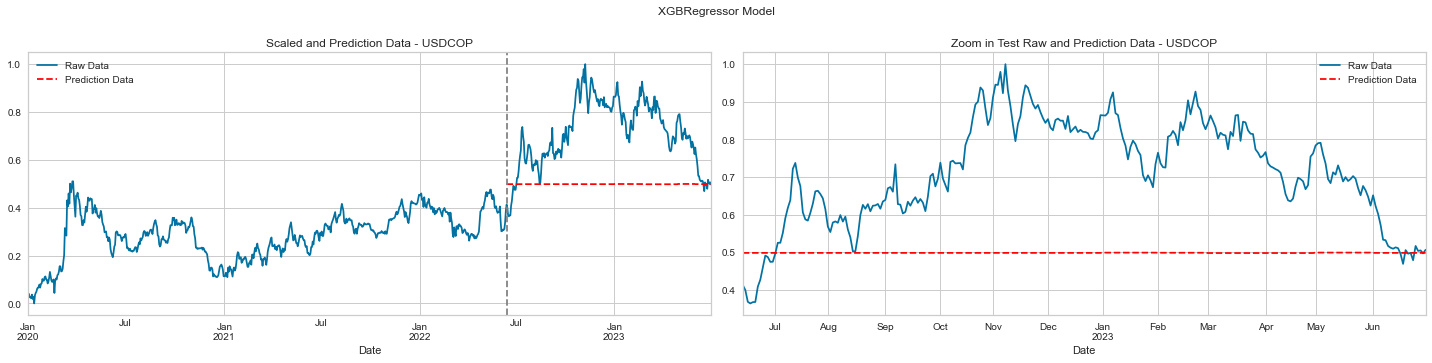

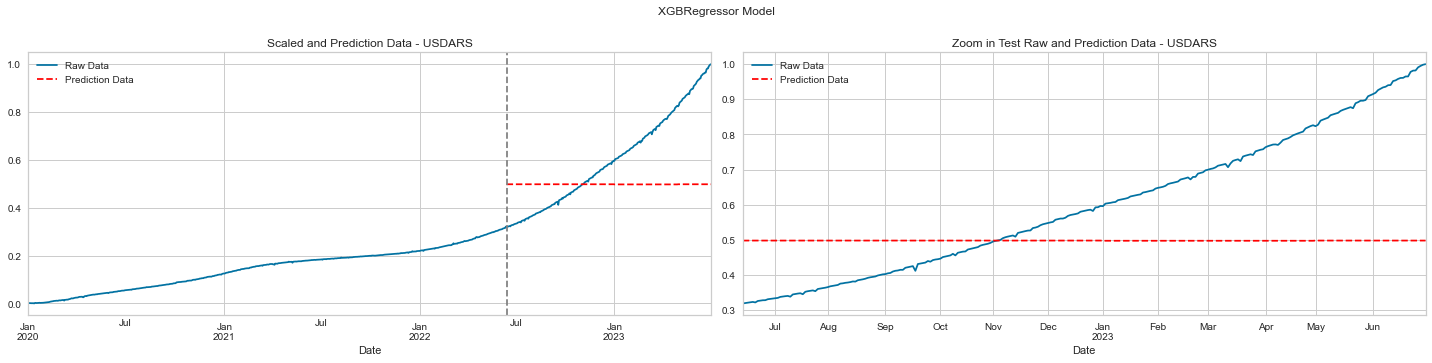

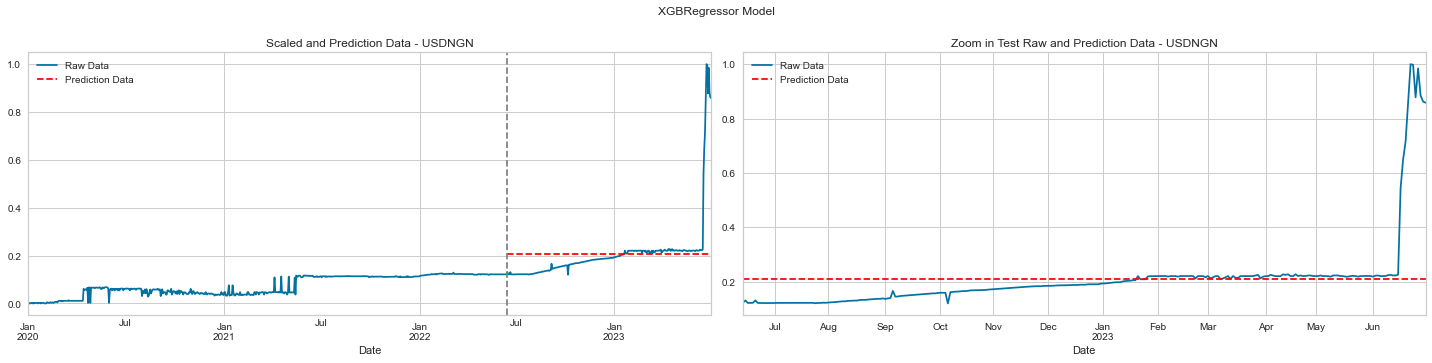

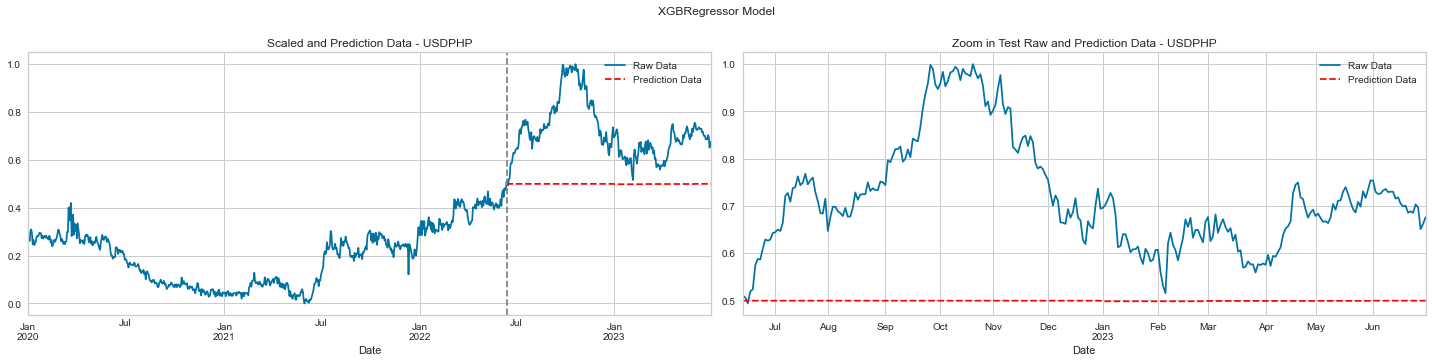

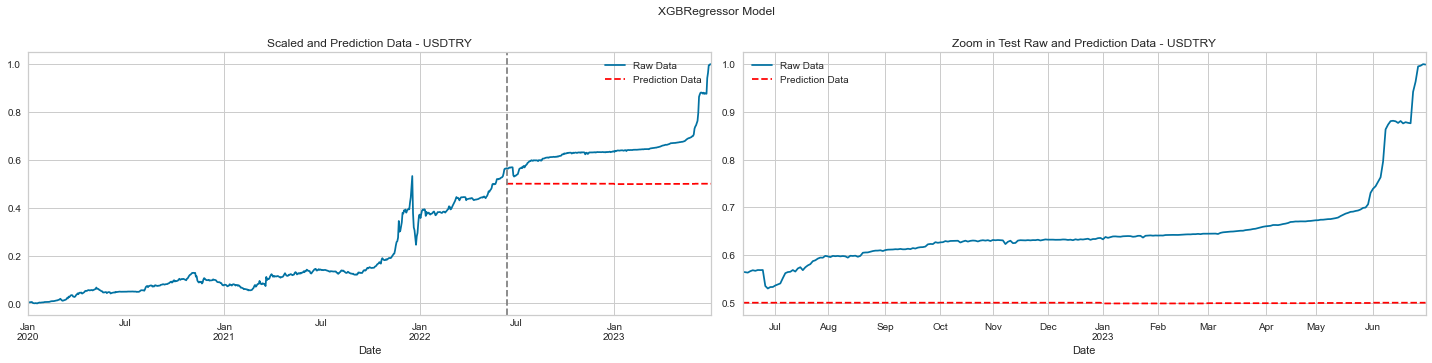

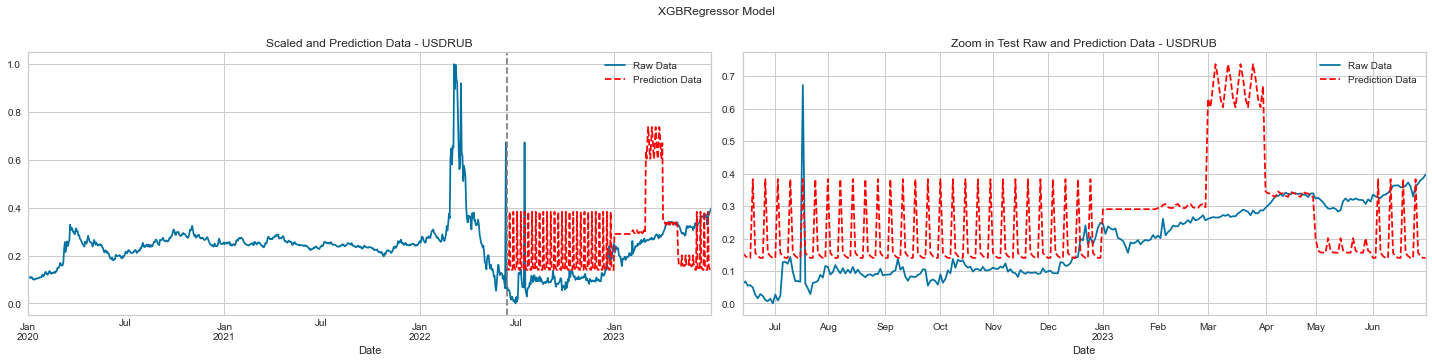

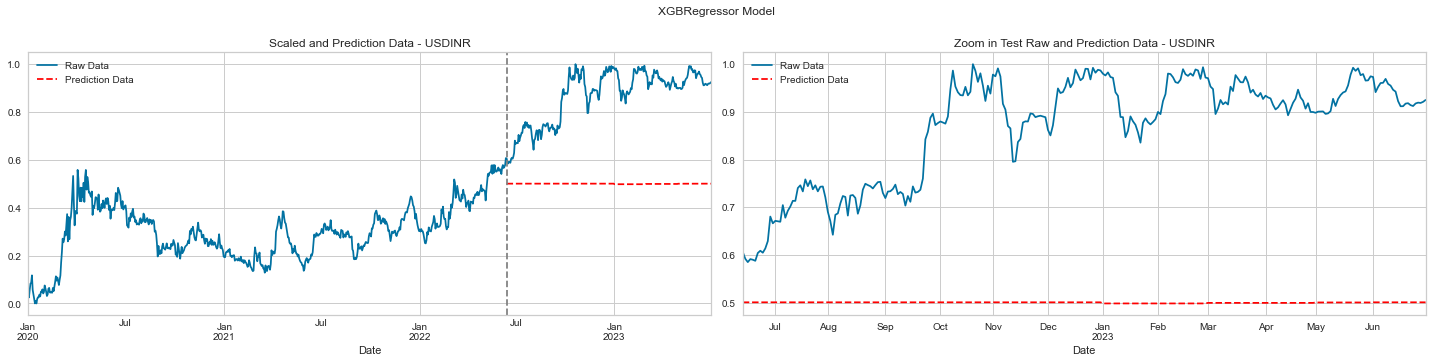

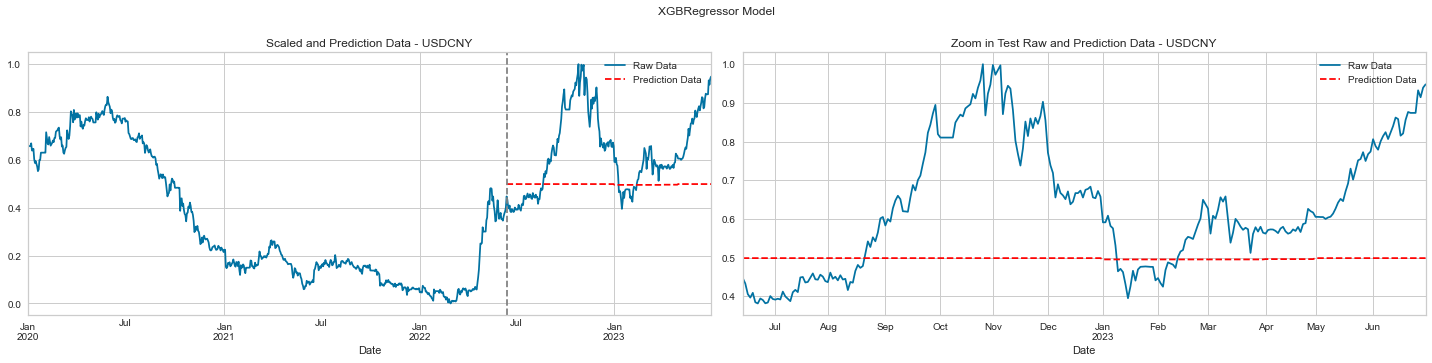

In [18]:
# Perform XGB across all currencies

for df, Currency in zip(dataframes, Currencies):
    XGB_Model(df)




## 3.2 Long Short-Term Memory (LSTM)

In [19]:
# Retrieve market data of currency symbol
Currency = 'USDCOP'
data = yf.download(Currency+'=X', start=start_date, end=end_date)

# Apply cleaning functions
add_pct_change(data)
replace_close(data)
replace_close(data)
Feature_Creation(data)

data

[*********************100%***********************]  1 of 1 completed


Open         High          Low        Close    Adj Close  \
Date                                                                          
2020-01-01  3279.760010  3279.760010  3279.760010  3279.760010  3279.760010   
2020-01-02  3279.760010  3281.080078  3241.714111  3279.760010  3279.760010   
2020-01-03  3252.750000  3266.750000  3252.469971  3252.750000  3252.750000   
2020-01-06  3252.250000  3253.560059  3245.520020  3256.899902  3256.899902   
2020-01-07  3244.459961  3262.600098  3202.010742  3244.459961  3244.459961   
...                 ...          ...          ...          ...          ...   
2023-06-26  4187.250000  4187.250000  4041.498291  4187.250000  4187.250000   
2023-06-27  4162.180176  4166.729980  4142.229980  4162.180176  4162.180176   
2023-06-28  4164.750000  4194.979980  4123.991699  4164.750000  4164.750000   
2023-06-29  4149.700195  4184.799805  4146.379883  4149.700195  4149.700195   
2023-06-30  4167.850098  4184.779785  4165.750000  4167.850098  4167.850098   

            Volume  Close_Change_Pct  CloseScaled  DayOfWeek  Month  Quarter  \
Date                                                                           
2020-01-01       0               NaN     0.039808          2      1        1   
2020-01-02       0          0.000000     0.039808          3      1        1   
2020-01-03       0         -0.008235     0.025607          4      1        1   
2020-01-06       0          0.001276     0.027789          0      1        1   
2020-01-07       0         -0.003820     0.021248          1      1        1   
...            ...               ...          ...        ...    ...      ...   
2023-06-26       0          0.017496     0.516944          0      6        2   
2023-06-27       0         -0.005987     0.503763          1      6        2   
2023-06-28       0          0.000617     0.505114          2      6        2   
2023-06-29       0         -0.003614     0.497201          3      6        2   
2023-06-30       0          0.004374     0.506744          4      6        2   

            Year  
Date              
2020-01-01  2020  
2020-01-02  2020  
2020-01-03  2020  
2020-01-06  2020  
2020-01-07  2020  
...          ...  
2023-06-26  2023  
2023-06-27  2023  
2023-06-28  2023  
2023-06-29  2023  
2023-06-30  2023  

[913 rows x 12 columns]

In [20]:
# Training Dataset

split_date = int(len(data) * 0.7)

train = np.array(data.CloseScaled.iloc[ :split_date]) # Train in 70% of first dates

X_train = []
y_train = []

for i in range(60, split_date):
    X_train.append(train[i-60:i])
    y_train.append(train[i])

X_train, y_train= np.array(X_train), np.array(y_train) # convert the train data into array
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) # Reshape the data

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')

X_train shape: (579, 60, 1)
y_train shape: (579,)


In [21]:
# Testing Dataset

test = np.array(data.CloseScaled.iloc[split_date: ]) # Test in 30% after split

X_test = []
y_test = data.Close.iloc[split_date+60: ] # normal values from original data

for i in range(60, len(test)):
    X_test.append(test[i-60:i])

X_test = np.array(X_test) # convert the train data into array
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1)) # Reshape the data
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_test shape: (214, 60, 1)
y_test shape: (214,)


In [22]:
# Create model LSTM

seq = Sequential() # Initializing the RNN
seq.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1))) # Adding the first LSTM layer
seq.add(LSTM(50, return_sequences=False)) # Adding the Second LSTM layer
seq.add(Dense(25))
seq.add(Dense(1))

seq.compile(optimizer='adam', loss='mean_squared_error')# Compile the model
seq.fit(X_train, y_train, batch_size=32, epochs=1)# Traing the model. Set the epochs=10 takes 10 minutes (100 takes too long)

19/19 [==============================] - 8s 85ms/step - loss: 0.0178


In [23]:
# Get model predicted values
scaler = MinMaxScaler()
scaler.fit(data.filter(['Close']).values)

pred = seq.predict(X_test)
pred = scaler.inverse_transform(pred) # "inverse scaled values to original values"

7/7 [==============================] - 2s 32ms/step


In [24]:
# calculate the mean squared error on the training data
mse_seq = mean_squared_error(y_test, pred)
rmse_seq = sqrt(mse_seq)

print(f'{Currency} MSE: {mse_seq:.2f}')
print(f'{Currency} RMSE: {rmse_seq:.2f}')

USDCOP MSE: 296348.07
USDCOP RMSE: 544.38


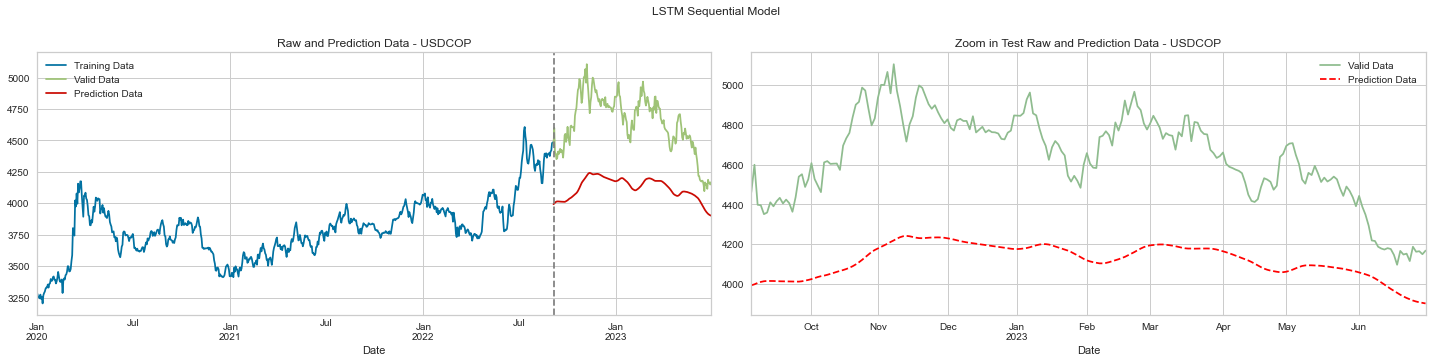

In [25]:
# Split Close non-scaled data into train and valid df
train_df = pd.DataFrame(data.Close.iloc[ :split_date+60]) # Train in 70% of first dates
valid_df = pd.DataFrame(data.Close.iloc[split_date+60: ]) # Test in 30% after split
valid_df['Prediction'] = pred # Add Predictions column with the inverse scaled values

# Plot the datasets and zoom in

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
plt.suptitle("LSTM Sequential Model").set_y(1)

train_df.plot(ax=ax1, label='Training Set', title=f'Raw and Prediction Data - {Currency}')
valid_df.plot(ax=ax1, label=['Valid Data','Prediction Data']).grid(True)
ax1.axvline(data.index[split_date+60], color='grey', ls='--')
ax1.legend(['Training Data', 'Valid Data','Prediction Data'])

valid_df['Close'].plot(ax = ax2, color='darkseagreen', title=f'Zoom in Test Raw and Prediction Data - {Currency}')
valid_df['Prediction'].plot(ax = ax2, style='--', color='red').grid(True)
ax2.axvline(data.index[split_date+60], color='grey', ls='--')
ax2.legend(['Valid Data', 'Prediction Data'])

plt.tight_layout()

In [26]:
# Show valid and predicted values
valid_df #.shape

Close   Prediction
Date                                
2022-09-06  4461.580078  3993.132324
2022-09-07  4600.000000  3998.256836
2022-09-08  4398.549805  4005.122314
2022-09-09  4396.000000  4010.195068
2022-09-12  4351.250000  4013.662354
...                 ...          ...
2023-06-26  4187.250000  3916.438477
2023-06-27  4162.180176  3911.614502
2023-06-28  4164.750000  3907.693848
2023-06-29  4149.700195  3904.587402
2023-06-30  4167.850098  3901.927246

[214 rows x 2 columns]

**Perform LSTM Sequential across all currencies**

In [27]:
# Define LSTM functions:

def LSTM_Model(data):

    # Apply cleaning functions on data
    add_pct_change(data)
    replace_close(data)
    replace_close(data)
    Feature_Creation(data)

    # Training Dataset
    split_date = int(len(data) * 0.7)
    train = np.array(data.CloseScaled.iloc[ :split_date]) # Train in 70% of first dates
    X_train = []
    y_train = []
    for i in range(60, split_date):
        X_train.append(train[i-60:i])
        y_train.append(train[i])
    X_train, y_train= np.array(X_train), np.array(y_train) # convert the train data into array
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) # Reshape the data

    # Testing Dataset
    test = np.array(data.CloseScaled.iloc[split_date: ]) # Test in 30% after split
    X_test = []
    y_test = data.Close.iloc[split_date+60: ] #normal values from original data
    for i in range(60, len(test)):
        X_test.append(test[i-60:i])
    X_test = np.array(X_test) # convert the train data into array
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))#Reshape the data

    # Create model LSTM
    seq = Sequential() # Initializing the RNN
    seq.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1))) # Adding the first LSTM layer
    seq.add(LSTM(50, return_sequences=False)) # Adding the Second LSTM layer
    seq.add(Dense(25))
    seq.add(Dense(1))
    seq.compile(optimizer='adam', loss='mean_squared_error')# Compile the model
    seq.fit(X_train, y_train, batch_size=32, epochs=1)# Traing the model. Set the epochs=10 takes 10 minutes (100 takes too long)

    # Get model predicted values
    scaler = MinMaxScaler()
    scaler.fit(data.filter(['Close']).values)
    pred = seq.predict(X_test)
    pred = scaler.inverse_transform(pred) # "inverse scaled values to original values"

    # Calculate the mean squared error on the training data
    mse_seq = mean_squared_error(y_test, pred)
    rmse_seq = sqrt(mse_seq)
    print(f'{Currency} RMSE: {rmse_seq:.2f}')

    # Split Close non-scaled data into train and valid df
    train_df = pd.DataFrame(data.Close.iloc[ :split_date+60]) # Train in 70% of first dates
    valid_df = pd.DataFrame(data.Close.iloc[split_date+60: ]) # Test in 30% after split
    valid_df['Prediction'] = pred # Add Predictions column with the inverse scaled values

    # Plot the Training and Testing data sets and zoom in
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
    plt.suptitle("LSTM Sequential Model").set_y(1)
    train_df.plot(ax=ax1, label='Training Set', title=f'Raw and Prediction Data - {Currency}')
    valid_df.plot(ax=ax1, label=['Valid Data','Prediction Data']).grid(True)
    ax1.axvline(data.index[split_date+60], color='grey', ls='--')
    ax1.legend(['Training Data', 'Valid Data','Prediction Data'])
    valid_df['Close'].plot(ax = ax2, color='darkseagreen', title=f'Zoom in Test Raw and Prediction Data - {Currency}')
    valid_df['Prediction'].plot(ax = ax2, style='--', color='red').grid(True)
    ax2.axvline(data.index[split_date+60], color='grey', ls='--')
    ax2.legend(['Valid Data', 'Prediction Data'])
    plt.tight_layout()

    return 

# LSTM_Model(data)

7/7 [==============================] - 1s 28ms/step
USDBRL RMSE: 0.19
7/7 [==============================] - 1s 32ms/step
USDMXN RMSE: 0.58
7/7 [==============================] - 1s 35ms/step
USDCOP RMSE: 586.12
7/7 [==============================] - 1s 34ms/step
USDARS RMSE: 38.99
7/7 [==============================] - 2s 38ms/step
USDNGN RMSE: 76.48
7/7 [==============================] - 2s 33ms/step
USDPHP RMSE: 2.13
7/7 [==============================] - 2s 34ms/step
USDTRY RMSE: 3.24
7/7 [==============================] - 2s 35ms/step
USDRUB RMSE: 6.43
7/7 [==============================] - 2s 36ms/step
USDINR RMSE: 3.93
7/7 [==============================] - 2s 35ms/step
USDCNY RMSE: 0.15


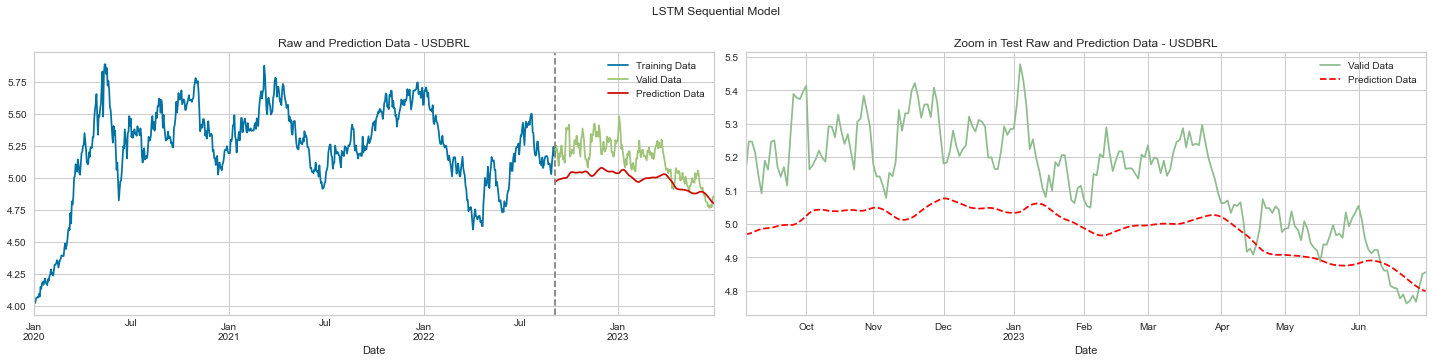

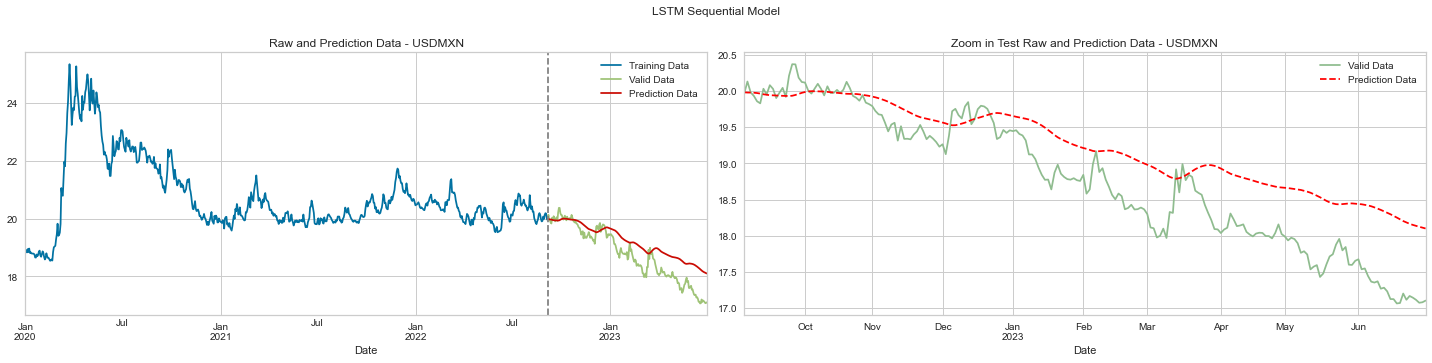

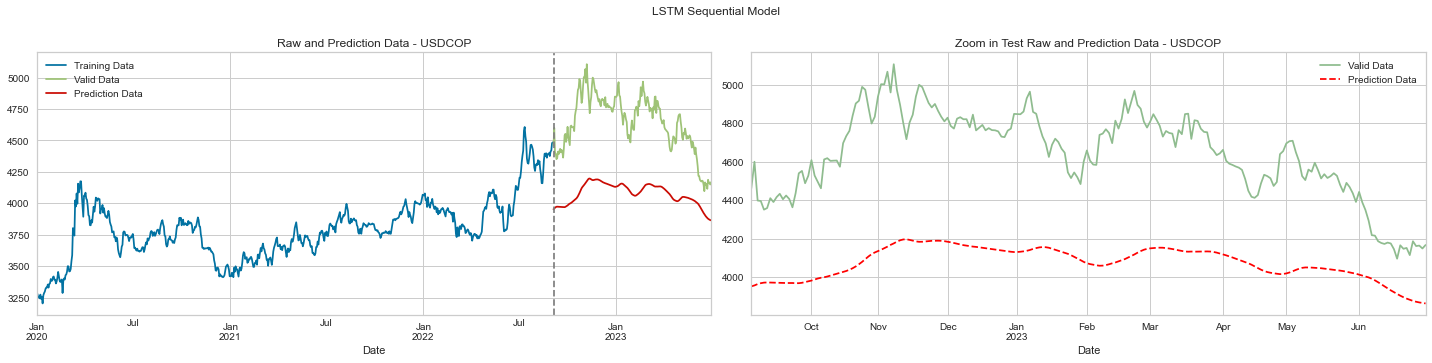

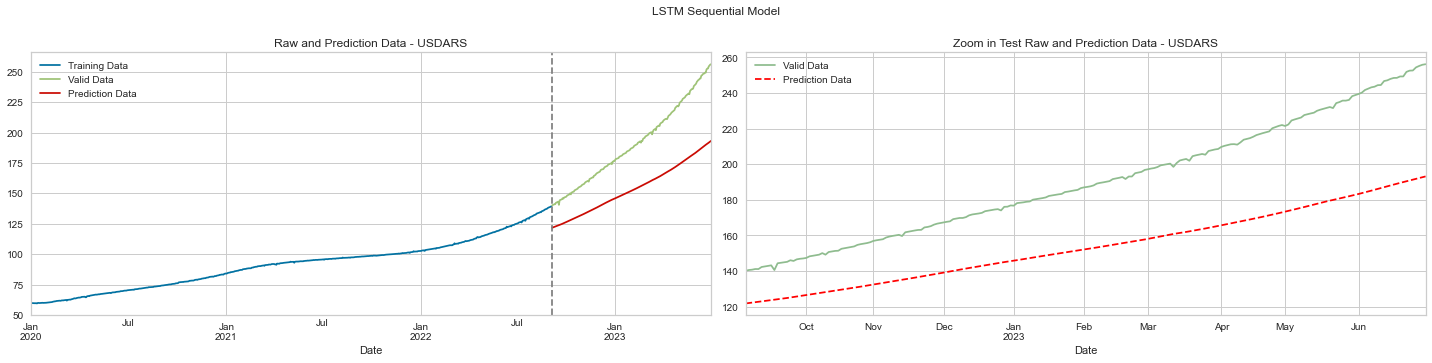

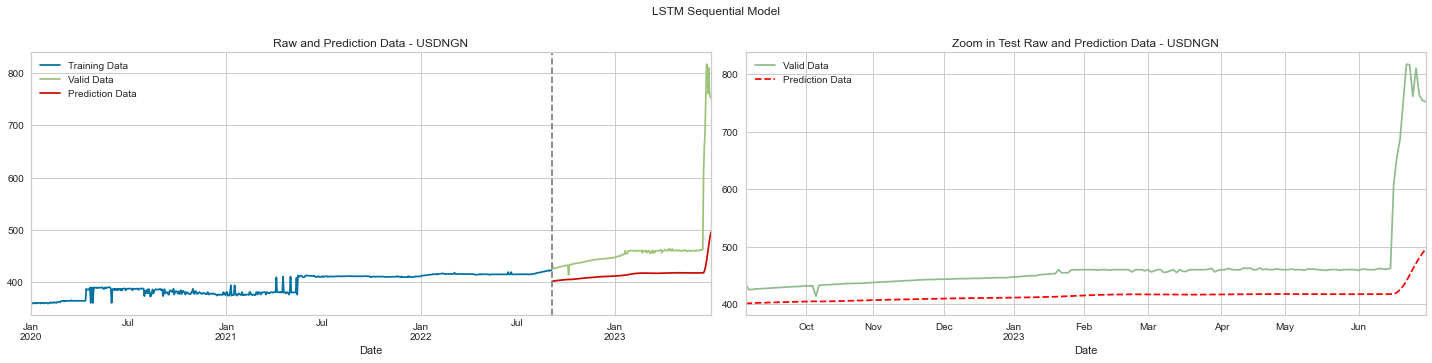

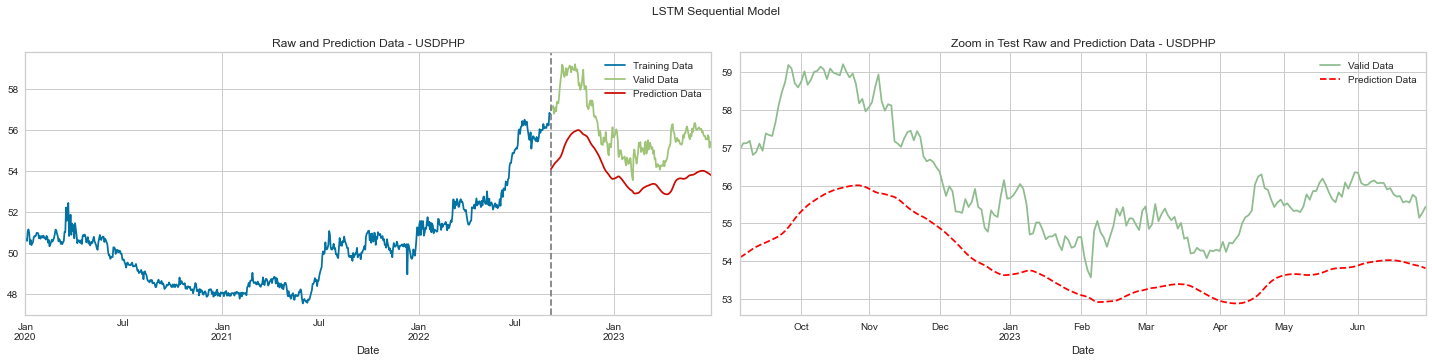

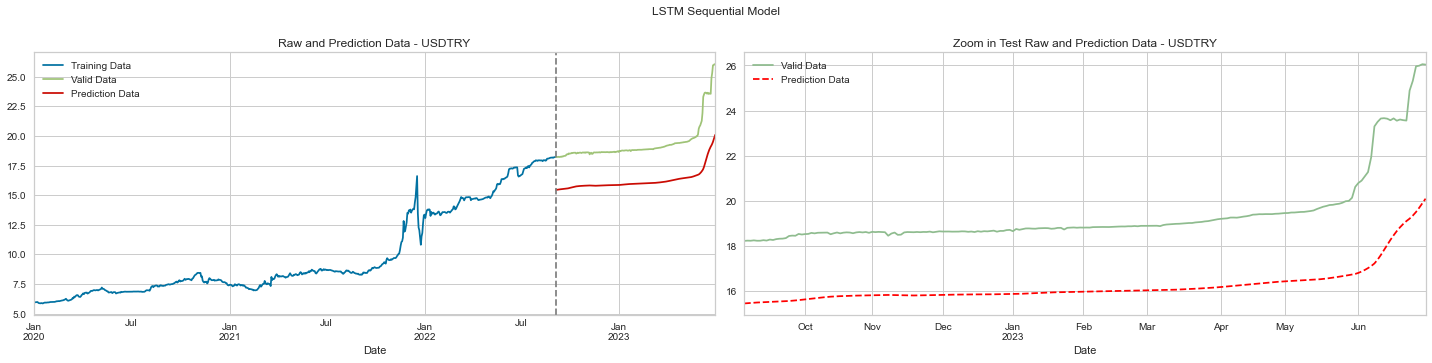

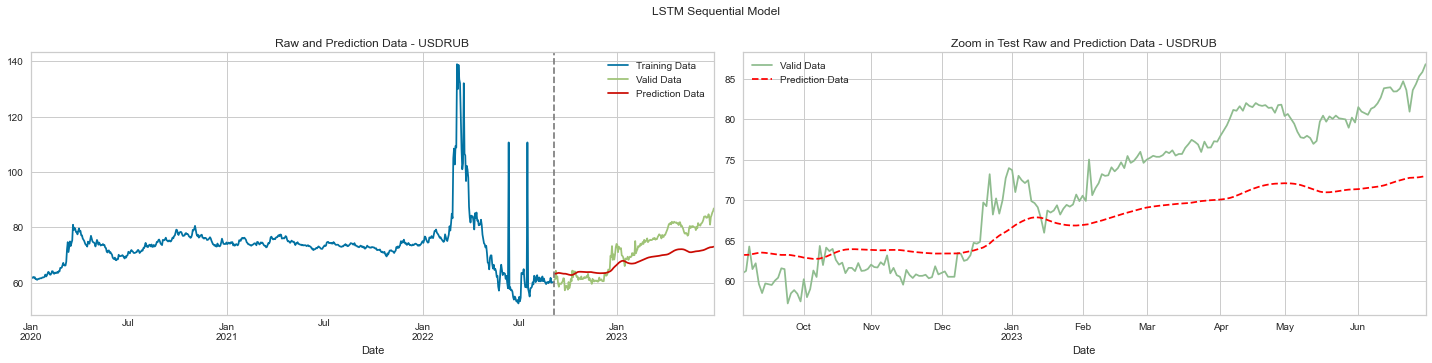

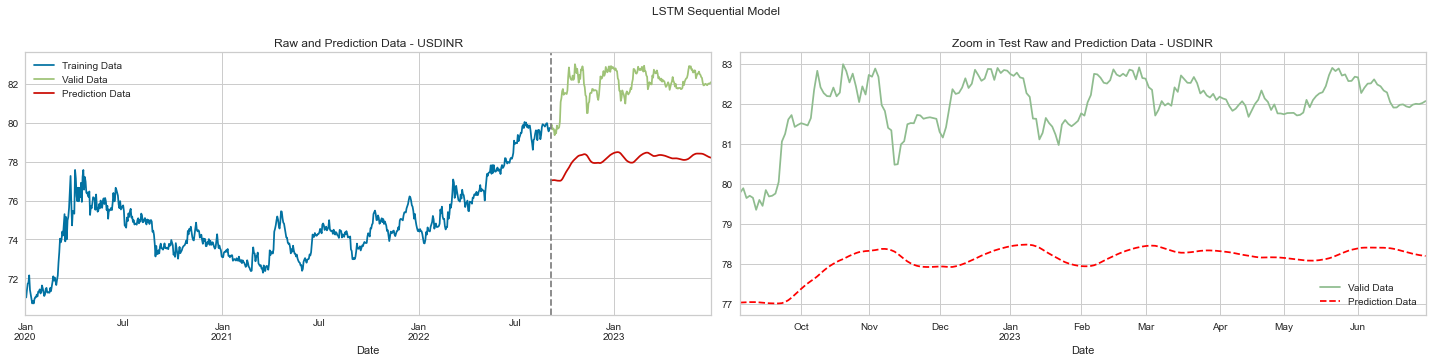

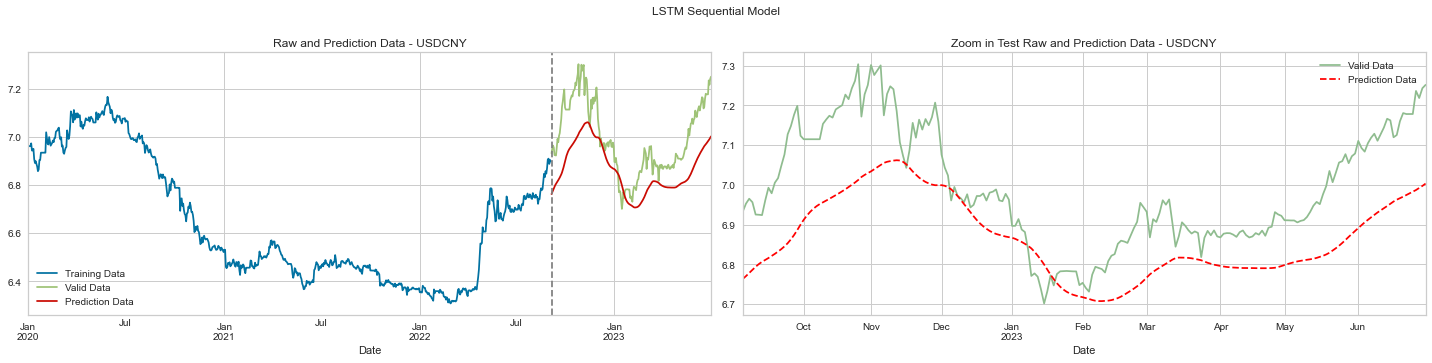

In [28]:
# Perform LSTM across all currencies

for df, Currency in zip(dataframes, Currencies):
    LSTM_Model(df)

## 3.3 Support Vector Classifier (SVC)

In [29]:
# Retrieve market data of currency symbol
Currency = 'USDCOP'
data = yf.download(Currency+'=X', start=start_date, end=end_date)

# Apply cleaning functions
add_pct_change(data)
replace_close(data)
replace_close(data)
data

[*********************100%***********************]  1 of 1 completed


Open         High          Low        Close    Adj Close  \
Date                                                                          
2020-01-01  3279.760010  3279.760010  3279.760010  3279.760010  3279.760010   
2020-01-02  3279.760010  3281.080078  3241.714111  3279.760010  3279.760010   
2020-01-03  3252.750000  3266.750000  3252.469971  3252.750000  3252.750000   
2020-01-06  3252.250000  3253.560059  3245.520020  3256.899902  3256.899902   
2020-01-07  3244.459961  3262.600098  3202.010742  3244.459961  3244.459961   
...                 ...          ...          ...          ...          ...   
2023-06-26  4187.250000  4187.250000  4041.498291  4187.250000  4187.250000   
2023-06-27  4162.180176  4166.729980  4142.229980  4162.180176  4162.180176   
2023-06-28  4164.750000  4194.979980  4123.991699  4164.750000  4164.750000   
2023-06-29  4149.700195  4184.799805  4146.379883  4149.700195  4149.700195   
2023-06-30  4167.850098  4184.779785  4165.750000  4167.850098  4167.850098   

            Volume  Close_Change_Pct  
Date                                  
2020-01-01       0               NaN  
2020-01-02       0          0.000000  
2020-01-03       0         -0.008235  
2020-01-06       0          0.001276  
2020-01-07       0         -0.003820  
...            ...               ...  
2023-06-26       0          0.017496  
2023-06-27       0         -0.005987  
2023-06-28       0          0.000617  
2023-06-29       0         -0.003614  
2023-06-30       0          0.004374  

[913 rows x 7 columns]

In [30]:
# Create independent and dependent variables
data['High-Low'] = data['High'] - data['Low']
data['Open-Close'] = data['Open'] - data['Close']
X = data[['Open-Close', 'High-Low', 'Close']] # Define independent variables

# Create signals: If tomorrow's close is > today's, then 1 increase, 0 otherwise
y = np.where(data.Close.shift(-1) > data.Close, 1, 0) # Target variable

# Training Dataset
split_date = int(len(data) * 0.7)
X_train = X[:split_date] 
y_train = y[:split_date]

# Testing Dataset
X_test = X[split_date:]
y_test = y[split_date:]

In [31]:
# Create the model SVC

svc = SVC()

svc.fit(X_train[['Open-Close', 'High-Low']],y_train)# Traing the model
svc_score_train = svc.score(X_train[['Open-Close', 'High-Low']],y_train)# score of the model on Train
svc_score_test = svc.score(X_test[['Open-Close', 'High-Low']],y_test)# score of the model on Test
print(f'Model Score on Train Dataset: {svc_score_train :.2f}')
print(f'Model Score on Test Dataset: {svc_score_test :.2f}')

data['Predictions'] = svc.predict(X[['Open-Close', 'High-Low']])# model predictions

data['Return'] = data['Close'].pct_change() # Calculate daily returns
data['Strat_Return'] = data['Predictions'].shift(1)*data['Return'] # Calculate strategy returns
data['Cumul_Return'] = data['Return'].cumsum() # Calculate cumulative returns
data['Cumul_Strat'] = data['Strat_Return'].cumsum() # Calculate strategy returns

data #.tail(3)

Model Score on Train Dataset: 0.62
Model Score on Test Dataset: 0.64


Open         High          Low        Close    Adj Close  \
Date                                                                          
2020-01-01  3279.760010  3279.760010  3279.760010  3279.760010  3279.760010   
2020-01-02  3279.760010  3281.080078  3241.714111  3279.760010  3279.760010   
2020-01-03  3252.750000  3266.750000  3252.469971  3252.750000  3252.750000   
2020-01-06  3252.250000  3253.560059  3245.520020  3256.899902  3256.899902   
2020-01-07  3244.459961  3262.600098  3202.010742  3244.459961  3244.459961   
...                 ...          ...          ...          ...          ...   
2023-06-26  4187.250000  4187.250000  4041.498291  4187.250000  4187.250000   
2023-06-27  4162.180176  4166.729980  4142.229980  4162.180176  4162.180176   
2023-06-28  4164.750000  4194.979980  4123.991699  4164.750000  4164.750000   
2023-06-29  4149.700195  4184.799805  4146.379883  4149.700195  4149.700195   
2023-06-30  4167.850098  4184.779785  4165.750000  4167.850098  4167.850098   

            Volume  Close_Change_Pct    High-Low  Open-Close  Predictions  \
Date                                                                        
2020-01-01       0               NaN    0.000000    0.000000            0   
2020-01-02       0          0.000000   39.365967    0.000000            0   
2020-01-03       0         -0.008235   14.280029    0.000000            0   
2020-01-06       0          0.001276    8.040039   -4.649902            0   
2020-01-07       0         -0.003820   60.589355    0.000000            0   
...            ...               ...         ...         ...          ...   
2023-06-26       0          0.017496  145.751709    0.000000            1   
2023-06-27       0         -0.005987   24.500000    0.000000            0   
2023-06-28       0          0.000617   70.988281    0.000000            1   
2023-06-29       0         -0.003614   38.419922    0.000000            0   
2023-06-30       0          0.004374   19.029785    0.000000            0   

              Return  Strat_Return  Cumul_Return  Cumul_Strat  
Date                                                           
2020-01-01       NaN           NaN           NaN          NaN  
2020-01-02  0.000000      0.000000      0.000000     0.000000  
2020-01-03 -0.008235     -0.000000     -0.008235     0.000000  
2020-01-06  0.001276      0.000000     -0.006960     0.000000  
2020-01-07 -0.003820     -0.000000     -0.010779     0.000000  
...              ...           ...           ...          ...  
2023-06-26  0.017496      0.017496      0.292883     1.198807  
2023-06-27 -0.005987     -0.005987      0.286896     1.192820  
2023-06-28  0.000617      0.000000      0.287513     1.192820  
2023-06-29 -0.003614     -0.003614      0.283900     1.189207  
2023-06-30  0.004374      0.000000      0.288273     1.189207  

[913 rows x 14 columns]

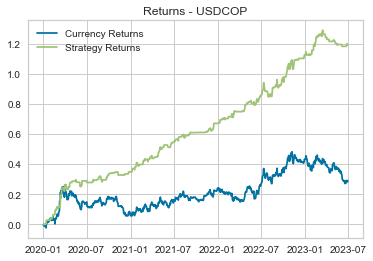

In [32]:
# Set Visuals

plt.title(f'Returns - {Currency}')
plt.plot(data['Cumul_Return'], label='Currency Returns')#.set_title('Returns')
plt.plot(data['Cumul_Strat'], label='Strategy Returns')
plt.legend()
plt.show()

In [33]:
# If this was a stock the return is from buying at time 0 and selling at current time. As a currency we can say it is the devaluation from time 0 to current time
print('Currency return:', round(data['Cumul_Return'][-1]*100, 2), '%') #the last row on Cumul_Return
print('Strategy return:', round(data['Cumul_Strat'][-1]*100, 2), '%') #the last row on Cumul_Strat

Currency return: 28.83 %
Strategy return: 118.92 %


**Perform SVC across all currencies**

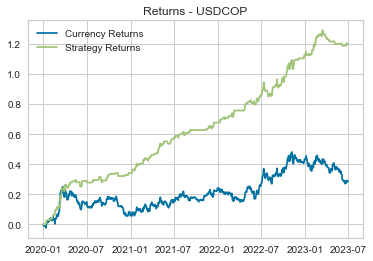

In [34]:
# Define SVC functions:

def SVC_Model(data):

    # Apply cleaning functions
    add_pct_change(data)
    replace_close(data)
    replace_close(data)

    # Create independent and dependent variables
    data['High-Low'] = data['High'] - data['Low']
    data['Open-Close'] = data['Open'] - data['Close']
    X = data[['Open-Close', 'High-Low', 'Close']] # Define independent variables
    # Create signals: If tomorrow's close is > today's, then 1 increase, 0 otherwise
    y = np.where(data.Close.shift(-1) > data.Close, 1, 0) # Target variable

    # Training Dataset
    split_date = int(len(data) * 0.9)
    X_train = X[:split_date]
    y_train = y[:split_date]
    # Testing Dataset
    X_test = X[split_date:]
    y_test = y[split_date:]

    # Create the model SVC
    svc = SVC()

    svc.fit(X_train[['Open-Close', 'High-Low']],y_train)# Traing the model
    svc_score_train = svc.score(X_train[['Open-Close', 'High-Low']],y_train)# score of the model on Train
    svc_score_test = svc.score(X_test[['Open-Close', 'High-Low']],y_test)# score of the model on Test

    data['Predictions'] = svc.predict(X[['Open-Close', 'High-Low']])# model predictions
    data['Return'] = data['Close'].pct_change() # Calculate daily returns
    data['Strat_Return'] = data['Predictions'].shift(1)*data['Return'] # Calculate strategy returns
    data['Cumul_Return'] = data['Return'].cumsum() # Calculate cumulative returns
    data['Cumul_Strat'] = data['Strat_Return'].cumsum() # Calculate strategy returns

    return

SVC_Model(data)

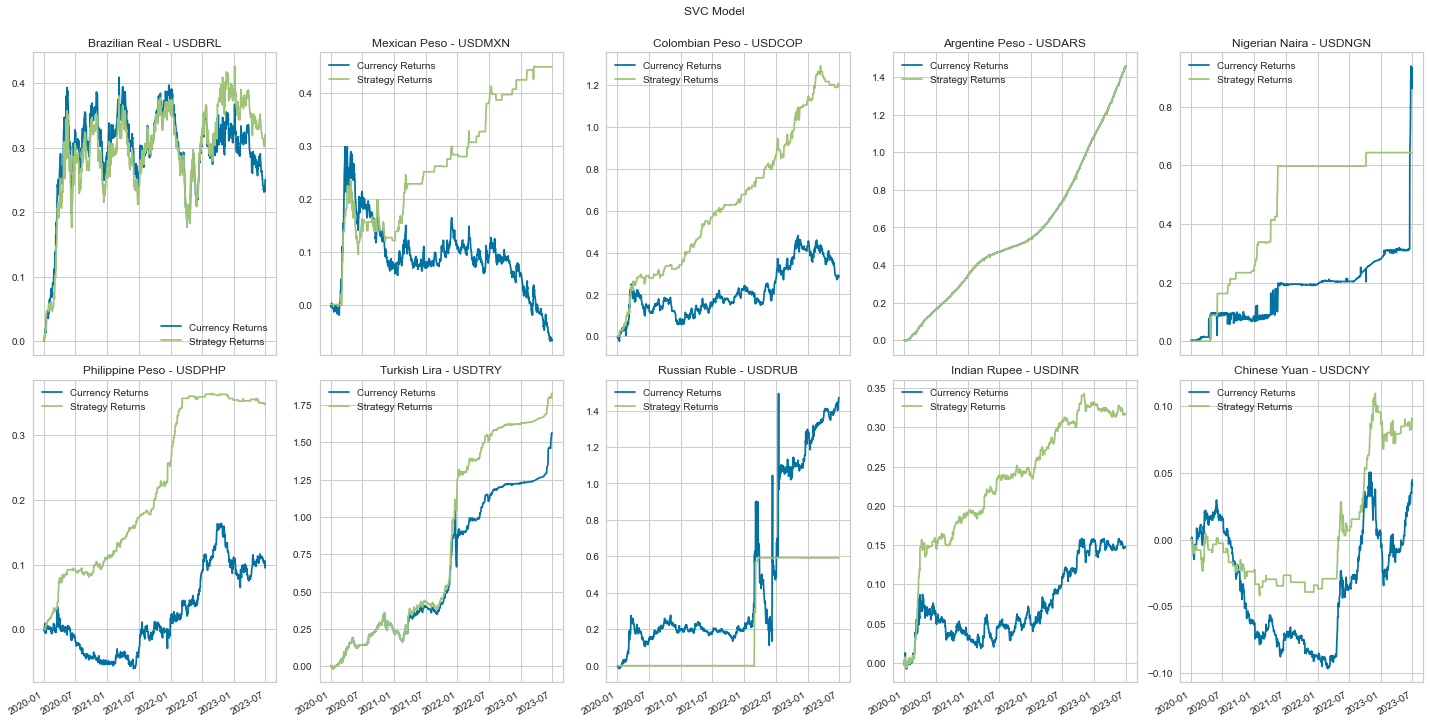

In [35]:
# Perform SVC across all currencies

fig, axes = plt.subplots(2,5, figsize=(20,10))
plt.suptitle("SVC Model").set_y(1)

for df, ax, currency, name in zip(dataframes, axes.flatten(), Currencies, currencies_names):
    SVC_Model(df)
    ax.plot(df['Cumul_Return'], label='Currency Returns')
    ax.plot(df['Cumul_Strat'], label='Strategy Returns')
    plt.gcf().autofmt_xdate()
    ax.set_title(name)
    ax.grid(True)
    ax.legend()

plt.tight_layout()

## 3.4 Random Forest Regressor (RFR)

In [36]:
# Retrieve market data of currency symbol
Currency = 'USDCOP'
data = yf.download(Currency+'=X', start=start_date, end=end_date)

# Apply cleaning functions
add_pct_change(data)
replace_close(data)
replace_close(data)
# data

[*********************100%***********************]  1 of 1 completed


In [37]:
# Split the dataset
X = data[['Open','High','Low']]
X_train = X[ :len(data)-1] # all rows but not the last one 
X_test = X.tail(1) # the last one row
y = data['Close']
y_train = y[ :len(data)-1] # all rows but not the last one
y_test = y.tail(1) # the last one row
# X_test.shape

In [38]:
# Create the model Random Forest Regressor
RFR = RandomForestRegressor()

# Train the model
RFR.fit(X_train,y_train)

# Test the model
predictions = RFR.predict(X_train)
print('The RFR score is:', (RFR.score(X_train,y_train)*100).round(3),'%')

The RFR score is: 99.983 %


In [39]:
# Make prediction

prediction = RFR.predict(X_test)
print(Currency,'prediction:')
print('RFR predicts the last day to be:', prediction.round(3))
print('Actual value is:',y_test.values[0].round(3)) # this should be the last value from the data imported
print('Difference between actual and predicted is:',(y_test.values[0] - prediction).round(3))

USDCOP prediction:
RFR predicts the last day to be: [4167.472]
Actual value is: 4167.85
Difference between actual and predicted is: [0.378]


**Perform Random Forest Regressor across all currencies**

In [40]:
# Define RFR functions:

def RFR_Model(data,Currency):

    # Split the dataset
    X = data[['Open','High','Low']]
    X_train = X[ :len(data)-1] # all rows but not the last one
    X_test = X.tail(1) # the last one row
    y = data['Close']
    y_train = y[ :len(data)-1] # all rows but not the last one
    y_test = y.tail(1) # the last one row

    # Create the model Random Forest Regressor
    RFR = RandomForestRegressor()

    # Train the model
    RFR.fit(X_train,y_train)

    # Test the model
    predictions = RFR.predict(X_train)

    # Make prediction
    prediction = RFR.predict(X_test)
    print(Currency,'prediction:')
    print('RFR score is:', (RFR.score(X_train,y_train)*100).round(3),'%')
    print('RFR predicts the last day to be:', prediction.round(3))
    print('Actual value is:',y_test.values[0].round(3)) # this should be the last value from the data imported
    print('Difference between actual and predicted is:',(y_test.values[0] - prediction).round(3))
    print()

    return

In [41]:
# Perform RFR across all currencies

for df, currency, name in zip(dataframes, Currencies, currencies_names):
    RFR_Model(df,name)


Brazilian Real - USDBRL prediction:
RFR score is: 99.966 %
RFR predicts the last day to be: [4.852]
Actual value is: 4.856
Difference between actual and predicted is: [0.004]

Mexican Peso - USDMXN prediction:
RFR score is: 99.996 %
RFR predicts the last day to be: [17.11]
Actual value is: 17.106
Difference between actual and predicted is: [-0.004]

Colombian Peso - USDCOP prediction:
RFR score is: 99.98 %
RFR predicts the last day to be: [4168.005]
Actual value is: 4167.85
Difference between actual and predicted is: [-0.155]

Argentine Peso - USDARS prediction:
RFR score is: 100.0 %
RFR predicts the last day to be: [255.385]
Actual value is: 256.185
Difference between actual and predicted is: [0.799]

Nigerian Naira - USDNGN prediction:
RFR score is: 99.794 %
RFR predicts the last day to be: [769.846]
Actual value is: 752.0
Difference between actual and predicted is: [-17.846]

Philippine Peso - USDPHP prediction:
RFR score is: 99.98 %
RFR predicts the last day to be: [55.435]
Actual 

## 3.5 Evaluating Models with Pycaret

In [42]:
# Retrieve market data of currency symbol
Currency = 'USDCOP'
data = yf.download(Currency+'=X', start=start_date, end=end_date)

# Apply cleaning functions
add_pct_change(data)
replace_close(data)
replace_close(data)
# data

[*********************100%***********************]  1 of 1 completed


In [43]:
future_days = 10 # variable for predicting days out into the future
data['Future_Price'] = data['Close'].shift(-future_days) # create a new column for the target feature shifted 'n days' up
data

Open         High          Low        Close    Adj Close  \
Date                                                                          
2020-01-01  3279.760010  3279.760010  3279.760010  3279.760010  3279.760010   
2020-01-02  3279.760010  3281.080078  3241.714111  3279.760010  3279.760010   
2020-01-03  3252.750000  3266.750000  3252.469971  3252.750000  3252.750000   
2020-01-06  3252.250000  3253.560059  3245.520020  3256.899902  3256.899902   
2020-01-07  3244.459961  3262.600098  3202.010742  3244.459961  3244.459961   
...                 ...          ...          ...          ...          ...   
2023-06-26  4187.250000  4187.250000  4041.498291  4187.250000  4187.250000   
2023-06-27  4162.180176  4166.729980  4142.229980  4162.180176  4162.180176   
2023-06-28  4164.750000  4194.979980  4123.991699  4164.750000  4164.750000   
2023-06-29  4149.700195  4184.799805  4146.379883  4149.700195  4149.700195   
2023-06-30  4167.850098  4184.779785  4165.750000  4167.850098  4167.850098   

            Volume  Close_Change_Pct  Future_Price  
Date                                                
2020-01-01       0               NaN   3286.750000  
2020-01-02       0          0.000000   3298.399902  
2020-01-03       0         -0.008235   3321.100098  
2020-01-06       0          0.001276   3330.760010  
2020-01-07       0         -0.003820   3330.500000  
...            ...               ...           ...  
2023-06-26       0          0.017496           NaN  
2023-06-27       0         -0.005987           NaN  
2023-06-28       0          0.000617           NaN  
2023-06-29       0         -0.003614           NaN  
2023-06-30       0          0.004374           NaN  

[913 rows x 8 columns]

In [44]:
# Split the dataset
X = data[['Close','Future_Price']]
X = X[ :len(data)-future_days] # all rows but not including the future days
y = data['Future_Price']
y = y[ :-future_days] # all rows but not including the future days

split_date = int(len(data) * 0.7)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=split_date, random_state=0, shuffle=False) # 70% training and 30% testing

In [45]:
# Initialize the setup
regression_setup = setup(data=X_train, target='Future_Price', session_id=123) 

In [46]:
# Train on all the models and sort it by the RMSE, then store the model with the best performance
comparing = compare_models(sort='RMSE') 

Processing:   0%|          | 0/81 [00:00<?, ?it/s]

In [47]:
# Create the best model and show its metrics on the training dataset
best_model = create_model(comparing) # The best model for each currency

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [48]:
evaluate_model(best_model) # Evaluate the best model

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [49]:
# Predictions on test dataset
unseen_predictions = predict_model(best_model, data=X_test) # The score should be updated now
data = pd.merge(data, unseen_predictions['prediction_label'], how='left', left_index=True, right_index=True) # Add the prediction_label to data
data

Open         High          Low        Close    Adj Close  \
Date                                                                          
2020-01-01  3279.760010  3279.760010  3279.760010  3279.760010  3279.760010   
2020-01-02  3279.760010  3281.080078  3241.714111  3279.760010  3279.760010   
2020-01-03  3252.750000  3266.750000  3252.469971  3252.750000  3252.750000   
2020-01-06  3252.250000  3253.560059  3245.520020  3256.899902  3256.899902   
2020-01-07  3244.459961  3262.600098  3202.010742  3244.459961  3244.459961   
...                 ...          ...          ...          ...          ...   
2023-06-26  4187.250000  4187.250000  4041.498291  4187.250000  4187.250000   
2023-06-27  4162.180176  4166.729980  4142.229980  4162.180176  4162.180176   
2023-06-28  4164.750000  4194.979980  4123.991699  4164.750000  4164.750000   
2023-06-29  4149.700195  4184.799805  4146.379883  4149.700195  4149.700195   
2023-06-30  4167.850098  4184.779785  4165.750000  4167.850098  4167.850098   

            Volume  Close_Change_Pct  Future_Price  prediction_label  
Date                                                                  
2020-01-01       0               NaN   3286.750000               NaN  
2020-01-02       0          0.000000   3298.399902               NaN  
2020-01-03       0         -0.008235   3321.100098               NaN  
2020-01-06       0          0.001276   3330.760010               NaN  
2020-01-07       0         -0.003820   3330.500000               NaN  
...            ...               ...           ...               ...  
2023-06-26       0          0.017496           NaN               NaN  
2023-06-27       0         -0.005987           NaN               NaN  
2023-06-28       0          0.000617           NaN               NaN  
2023-06-29       0         -0.003614           NaN               NaN  
2023-06-30       0          0.004374           NaN               NaN  

[913 rows x 9 columns]

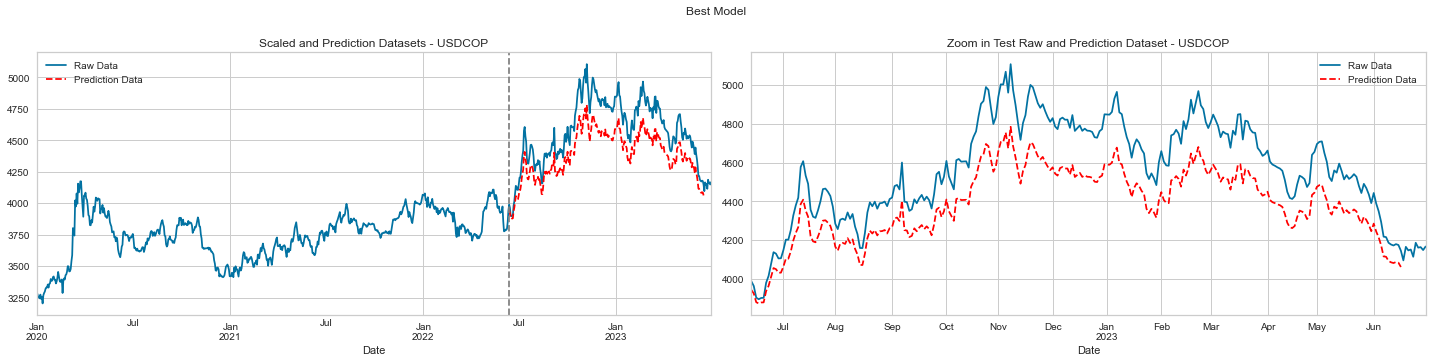

In [50]:
# Visualize Scaled / Predictions and Zoom in

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
plt.suptitle("Best Model").set_y(1)

data['Close'].plot(ax=ax1, title=f'Scaled and Prediction Datasets - {Currency}')
data[['prediction_label']].plot(ax=ax1, style='--', color='red').grid(True)
ax1.axvline(data.index[split_date], color='grey', ls='--')
ax1.legend(['Raw Data', 'Prediction Data'])

data.loc[data.index >= data.index[split_date]]['Close'].plot(ax=ax2, title=f'Zoom in Test Raw and Prediction Dataset - {Currency}')
data.loc[data.index >= data.index[split_date]]['prediction_label'].plot(ax=ax2, style='--', color='red').grid(True)
ax2.axvline(data.index[split_date], color='grey', ls='--')
ax2.legend(['Raw Data', 'Prediction Data'])

plt.tight_layout()

**Perform Pycaret evaluating models across all currencies**

In [51]:
# Define Pycaret functions:

def Comparing_Model(data):

    # Apply cleaning functions on data
    add_pct_change(data)
    replace_close(data)
    replace_close(data)

    future_days = 10 # variable for predicting days out into the future
    data['Future_Price'] = data['Close'].shift(-future_days) # create a new column for the target feature shifted 'n days' up

    X = data[['Close','Future_Price']]
    X = X[ :len(data)-future_days] # all rows but not the future days
    y = data['Future_Price']
    y = y[ :-future_days] # all rows but not the future days
    split_date = int(len(data) * 0.7) # Change the % to train data 
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=split_date, random_state=0, shuffle=False) 

    print('\n \033[1m' + Currency + '\033[0m')
    regression_setup = setup(data=X_train, target='Future_Price', session_id=123) # Initialize the setup
    comparing = compare_models(sort='RMSE') # Also sort by RMSE?descending??
    best_model = create_model(comparing) # The best model for each currency
    unseen_predictions = predict_model(best_model, data=X_test)
    data = pd.merge(data, unseen_predictions['prediction_label'], how='left', left_index=True, right_index=True)

    # Visualize Scaled / Predictions and Zoom in
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
    plt.suptitle("Best Model").set_y(1)
    data['Close'].plot(ax=ax1, title=f'Scaled and Prediction Datasets - {Currency}')
    data[['prediction_label']].plot(ax=ax1, style='--', color='red').grid(True)
    ax1.axvline(data.index[split_date], color='grey', ls='--')
    ax1.legend(['Raw Data', 'Prediction Data'])
    data.loc[data.index >= data.index[split_date]]['Close'].plot(ax=ax2, title=f'Zoom in Test Raw and Prediction Dataset - {Currency}')
    data.loc[data.index >= data.index[split_date]]['prediction_label'].plot(ax=ax2, style='--', color='red').grid(True)
    ax2.axvline(data.index[split_date], color='grey', ls='--')
    ax2.legend(['Raw Data', 'Prediction Data'])
    plt.tight_layout()

    return 


 USDBRL


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

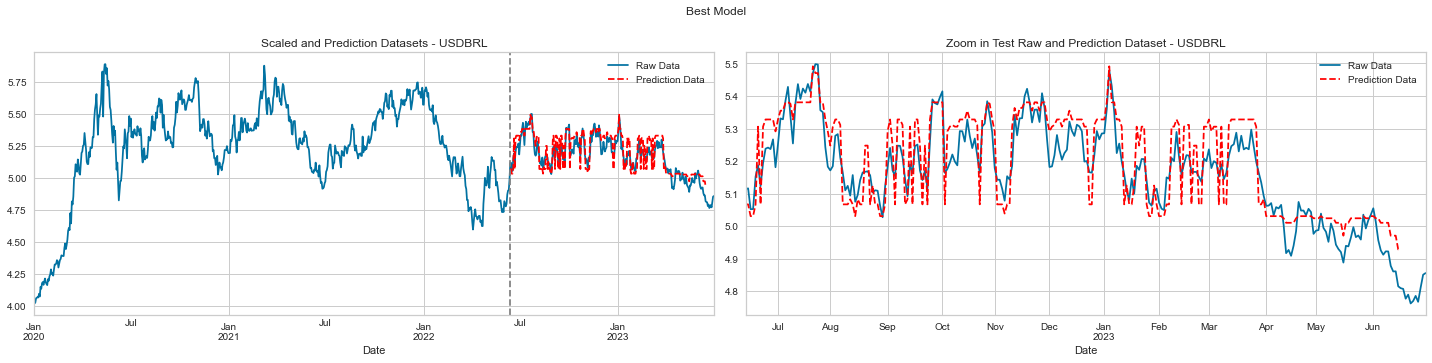


 USDMXN


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

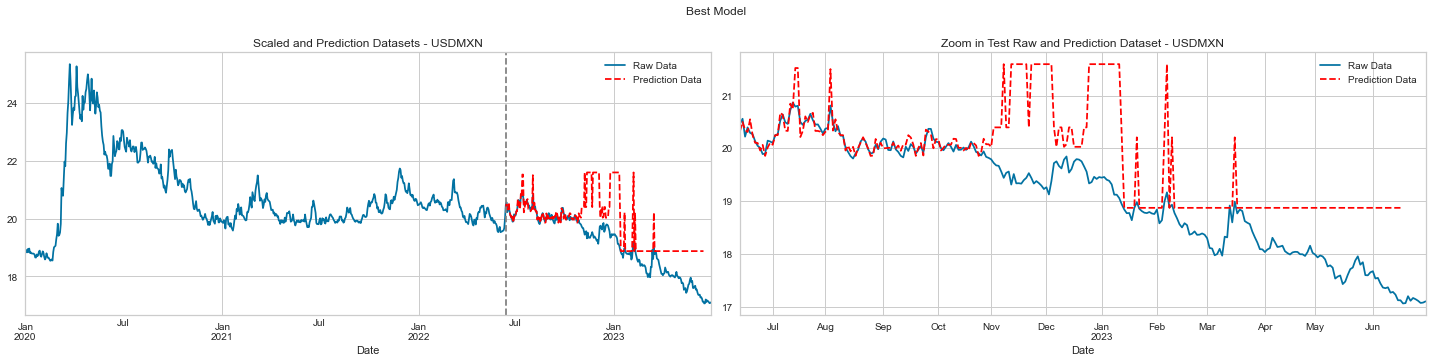


 USDCOP


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

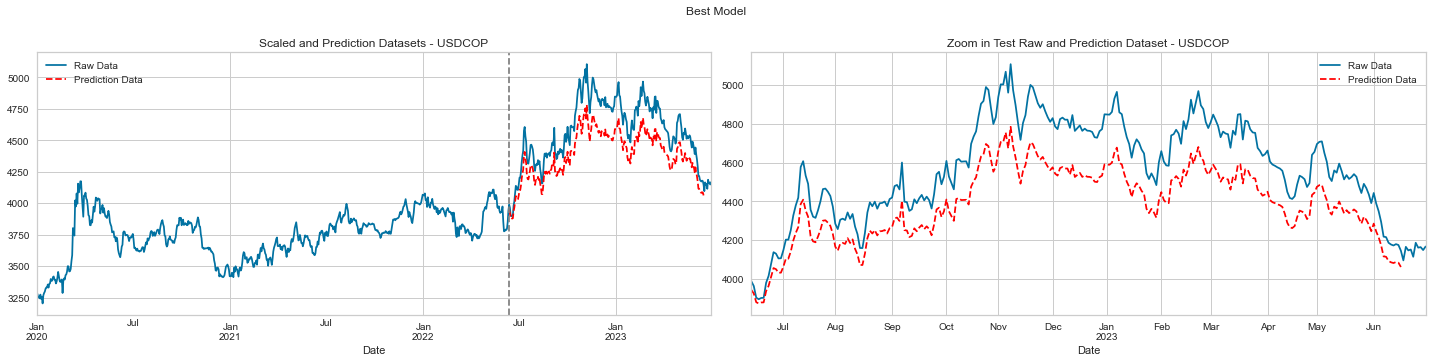


 USDARS


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

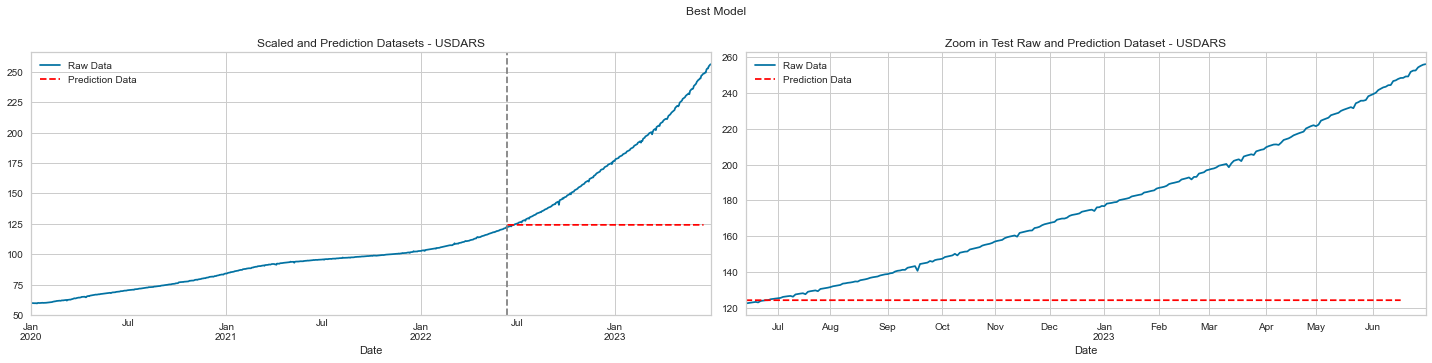


 USDNGN


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

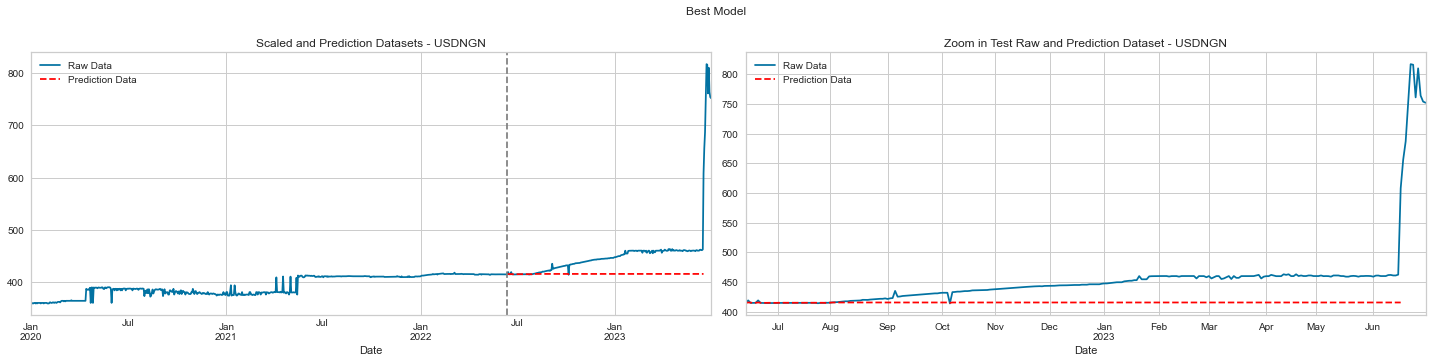


 USDPHP


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

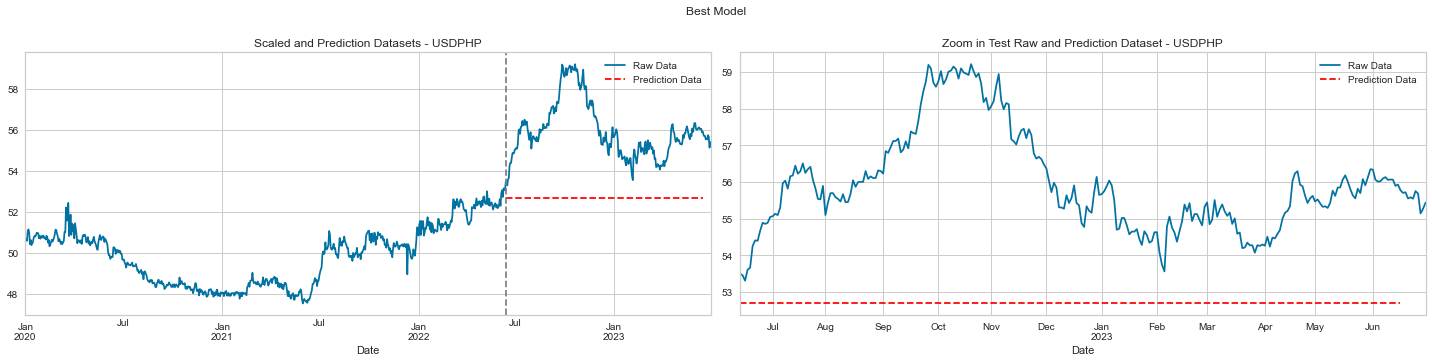


 USDTRY


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

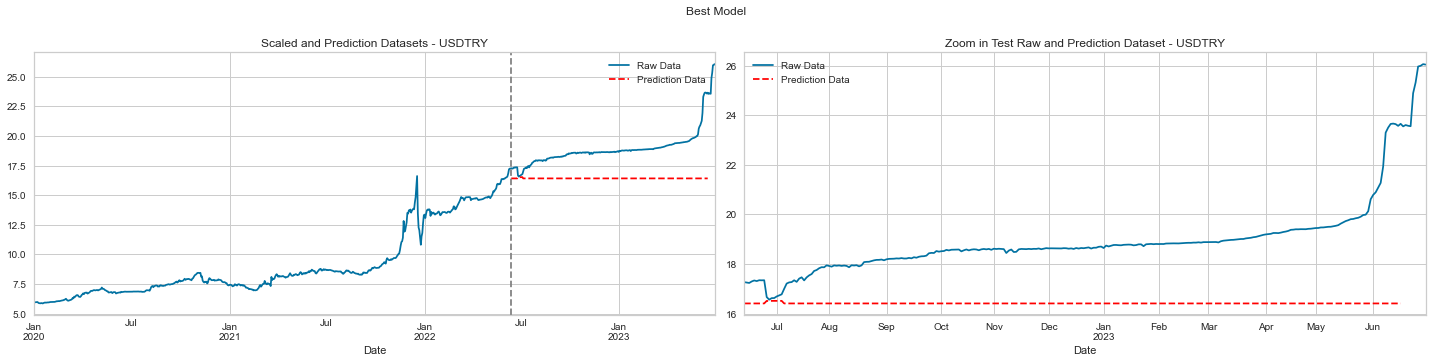


 USDRUB


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

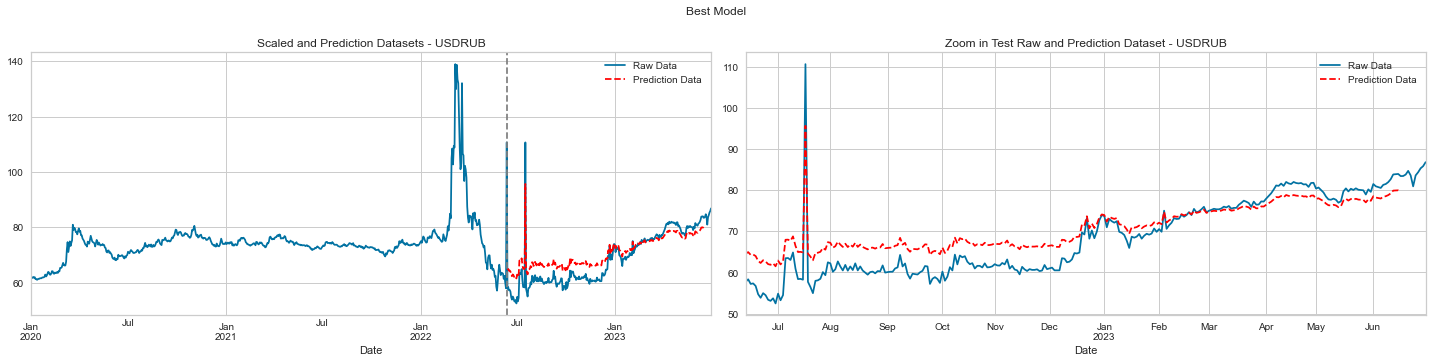


 USDINR


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

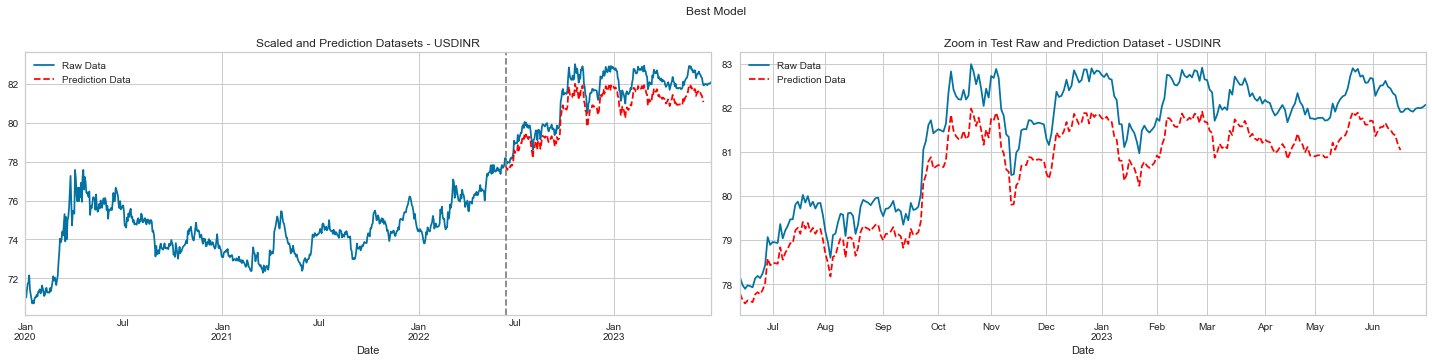


 USDCNY


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

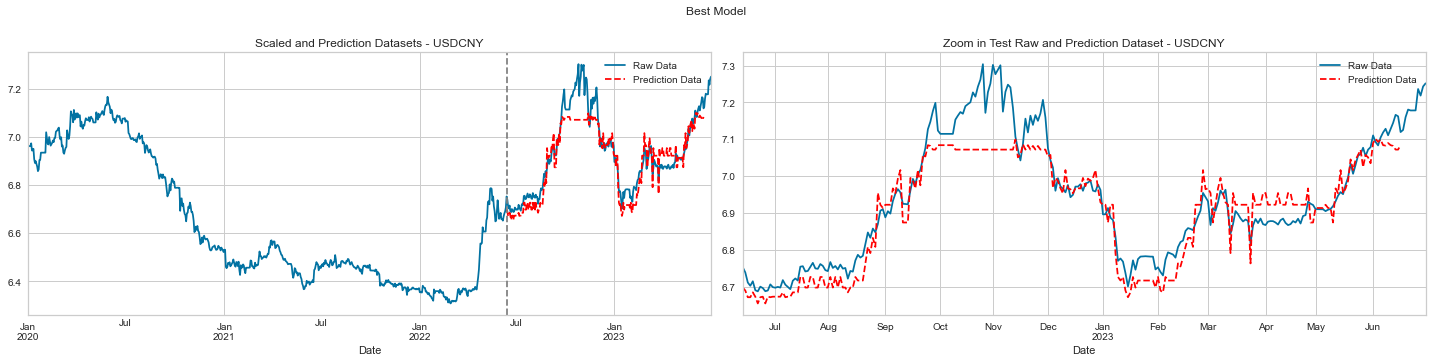

In [52]:
# Perform Pycaret evaluating models across all currencies

for df, Currency in zip(dataframes, Currencies):
    if Currency==Currencies[0]: 
        Comparing_Model(df)
plt.show()

for df, Currency in zip(dataframes, Currencies):
    if Currency==Currencies[1]: 
        Comparing_Model(df)
plt.show()

for df, Currency in zip(dataframes, Currencies):
    if Currency==Currencies[2]: 
        Comparing_Model(df)
plt.show()

for df, Currency in zip(dataframes, Currencies):
    if Currency==Currencies[3]: 
        Comparing_Model(df)
plt.show()

for df, Currency in zip(dataframes, Currencies):
    if Currency==Currencies[4]: 
        Comparing_Model(df)
plt.show()

for df, Currency in zip(dataframes, Currencies):
    if Currency==Currencies[5]: 
        Comparing_Model(df)
plt.show()

for df, Currency in zip(dataframes, Currencies):
    if Currency==Currencies[6]: 
        Comparing_Model(df)
plt.show()

for df, Currency in zip(dataframes, Currencies):
    if Currency==Currencies[7]: 
        Comparing_Model(df)
plt.show()

for df, Currency in zip(dataframes, Currencies):
    if Currency==Currencies[8]: 
        Comparing_Model(df)
plt.show()

for df, Currency in zip(dataframes, Currencies):
    if Currency==Currencies[9]: 
        Comparing_Model(df)
plt.show()


<a id="References"></a>
### References:
0. Dataset: U.S. Airbnb Open Data - https://www.kaggle.com/kritikseth/us-airbnb-open-data
1. Multiple linear regression: theory and applications. Towardsdatascience. https://towardsdatascience.com/multiple-linear-regression-theory-and-applications-677ec2cd04ac <a id='3'></a>
2. Decision tree. Wikipedia. https://en.wikipedia.org/wiki/Decision_tree
3. Applications of decision trees. SpringerLink. https://link.springer.com/chapter/10.1007/978-981-15-1706-8_9.
4. Cite the videos as references???

LSTM: Stock Prediction using Machine Learning and Python | Machine Learning Training | Edureka \
SVM: Video A Machine Learning Stock Trading Strategy Using Python \
Compare many models: Bitcoin Future Price Prediction Using Python & Machine Learning \
Machine Learning Stock Prediction Using Random Forest Regressor

In [53]:
# Print the time of execution of entire code string
time_end = datetime.now() 
print(f'Time of execution: {time_end - time_start}')

Time of execution: 1:16:14.684956
